# Optuna LightGBM Tuner

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',90)

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.shape

(1460, 81)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# drop columns
drop_columns=['Alley','PoolQC','Fence','MiscFeature','Id','PoolArea']
train.drop(drop_columns,axis=1,inplace=True)
test.drop(drop_columns,axis=1,inplace=True)

In [8]:
# area features fill nan
area_list = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
             'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
             'ScreenPorch']
for i in area_list:
    train[i].fillna(train[i].mean(),inplace=True)
    test[i].fillna(train[i].mean(),inplace=True)

In [9]:
# fill nan
for i in train.columns:
    train[i] = train[i].fillna(mode(train[i])[0][0])
for i in test.columns:
    test[i] = test[i].fillna(mode(test[i])[0][0])

In [10]:
# take out categorical data
onehot_list = []
for i in train.columns:
    if type(train[i][0]) == str:
        onehot_list.append(i)

In [11]:
# add age data
train['age']=train['YrSold']-train['YearBuilt']
test['age']=test['YrSold']-test['YearBuilt']
train['garage_age']=train['YrSold']-train['GarageYrBlt']
test['garage_age']=test['YrSold']-test['GarageYrBlt']
train['age2']=train['YrSold']-train['YearRemodAdd']
test['age2']=test['YrSold']-test['YearRemodAdd']

In [12]:
# label-encoding
for i in onehot_list:
    l = LabelEncoder().fit(train[i])
    train[i] = l.transform(train[i])
    test[i] = l.transform(test[i])

In [13]:
# # train_test_splits
# data_x = train.drop('SalePrice',axis=1)
# data_y = train['SalePrice']
# x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,test_size=0.2,random_state=0)

In [14]:
X_train = train.drop([ 'SalePrice'], axis=1)
y_train = np.log1p(train['SalePrice'])

# create model (lightgbm)

In [15]:
import optuna.integration.lightgbm as lgb
#import lightgbm as lgb

In [16]:
# Original
# model = lgb.LGBMRegressor(n_estimators=669,subsample=0.8,max_depth=6,
#                                feature_fraction=0.7,
#                                 min_child_samples=14,num_leaves=31)

In [17]:
# model.fit(x_train,y_train,categorical_feature=onehot_list,eval_set=(x_test,y_test),eval_metric=['rmse'])

In [18]:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [19]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)


params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            #categorical_feature=categorical_cols
                           )

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           #categorical_feature=categorical_cols
                          )

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

[I 2020-10-23 12:50:00,531] A new study created in memory with name: no-name-b7e3bb89-08ab-47ee-b909-899a37e4f29a
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.195668	valid_1's rmse: 0.19553
[20]	training's rmse: 0.123163	valid_1's rmse: 0.145791
[30]	training's rmse: 0.095103	valid_1's rmse: 0.136455
[40]	training's rmse: 0.0814201	valid_1's rmse: 0.134257
[50]	training's rmse: 0.0720096	valid_1's rmse: 0.132441
[60]	training's rmse: 0.0650175	valid_1's rmse: 0.13067
[70]	training's rmse: 0.0593402	valid_1's rmse: 0.130286
Early stopping, best iteration is:
[65]	training's rmse: 0.0620271	valid_1's rmse: 0.130124


feature_fraction, val_score: 0.130124:  14%|######4                                      | 1/7 [00:00<00:00,  7.19it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.188402	valid_1's rmse: 0.191118
[20]	training's rmse: 0.115976	valid_1's rmse: 0.145607
[30]	training's rmse: 0.0891932	valid_1's rmse: 0.138168
[40]	training's rmse: 0.0754537	valid_1's rmse: 0.13845
Early stopping, best iteration is:
[33]	training's rmse: 0.0841447	valid_1's rmse: 0.13748


feature_fraction, val_score: 0.130124:  29%|############8                                | 2/7 [00:00<00:00,  7.19it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190613	valid_1's rmse: 0.193074
[20]	training's rmse: 0.11765	valid_1's rmse: 0.148018
[30]	training's rmse: 0.0913657	valid_1's rmse: 0.140011
[40]	training's rmse: 0.0786349	valid_1's rmse: 0.138941
[50]	training's rmse: 0.0696998	valid_1's rmse: 0.138613
[60]	training's rmse: 0.0628257	valid_1's rmse: 0.138264
[70]	training's rmse: 0.0571993	valid_1's rmse: 0.137807
[80]	training's rmse: 0.0527159	valid_1's rmse: 0.137298
[90]	training's rmse: 0.0485324	valid_1's rmse: 0.136864
[100]	training's rmse: 0.0445789	valid_1's rmse: 0.136661
[110]	training's rmse: 0.0412773	valid_1's rmse: 0.136371
[120]	training's rmse: 0.0385	valid_1's rmse: 0.136256
[130]	training's rmse: 0.0359964	valid_1's rmse: 0.135736
[140]	training's rmse: 0.0337108	valid_1's rmse: 0.135776
Early stopping, best iteration is:
[135]	training's rmse: 0.0347779	valid_1's rmse: 0.135643


feature_fraction, val_score: 0.130124:  43%|###################2                         | 3/7 [00:00<00:00,  6.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.188741	valid_1's rmse: 0.190424
[20]	training's rmse: 0.116335	valid_1's rmse: 0.143585
[30]	training's rmse: 0.0896603	valid_1's rmse: 0.1367
[40]	training's rmse: 0.076018	valid_1's rmse: 0.135954
[50]	training's rmse: 0.0672368	valid_1's rmse: 0.136078
Early stopping, best iteration is:
[42]	training's rmse: 0.0740294	valid_1's rmse: 0.135639


feature_fraction, val_score: 0.130124:  57%|#########################7                   | 4/7 [00:00<00:00,  7.12it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.192589	valid_1's rmse: 0.192574
[20]	training's rmse: 0.119471	valid_1's rmse: 0.143394
[30]	training's rmse: 0.093096	valid_1's rmse: 0.13653
[40]	training's rmse: 0.079762	valid_1's rmse: 0.135743
[50]	training's rmse: 0.0715165	valid_1's rmse: 0.136164
Early stopping, best iteration is:
[40]	training's rmse: 0.079762	valid_1's rmse: 0.135743


feature_fraction, val_score: 0.130124:  71%|################################1            | 5/7 [00:00<00:00,  7.49it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189228	valid_1's rmse: 0.192561
[20]	training's rmse: 0.117148	valid_1's rmse: 0.14668
[30]	training's rmse: 0.0911373	valid_1's rmse: 0.13945
[40]	training's rmse: 0.0780227	valid_1's rmse: 0.137574
[50]	training's rmse: 0.0693261	valid_1's rmse: 0.136534
[60]	training's rmse: 0.0626483	valid_1's rmse: 0.136796
Early stopping, best iteration is:
[50]	training's rmse: 0.0693261	valid_1's rmse: 0.136534


feature_fraction, val_score: 0.130124:  86%|######################################5      | 6/7 [00:00<00:00,  7.47it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.188353	valid_1's rmse: 0.19249
[20]	training's rmse: 0.116032	valid_1's rmse: 0.147004
[30]	training's rmse: 0.0889829	valid_1's rmse: 0.138596
[40]	training's rmse: 0.0753857	valid_1's rmse: 0.137353
[50]	training's rmse: 0.0670351	valid_1's rmse: 0.136546
[60]	training's rmse: 0.0604898	valid_1's rmse: 0.135993
[70]	training's rmse: 0.0547685	valid_1's rmse: 0.135823
[80]	training's rmse: 0.0498468	valid_1's rmse: 0.134688
[90]	training's rmse: 0.0456554	valid_1's rmse: 0.134384
[100]	training's rmse: 0.0422242	valid_1's rmse: 0.134035
[110]	training's rmse: 0.0389487	valid_1's rmse: 0.133686
[120]	training's rmse: 0.0363182	valid_1's rmse: 0.133767
[130]	training's rmse: 0.0339415	valid_1's rmse: 0.133484
[140]	training's rmse: 0.0318722	valid_1's rmse: 0.133277
[150]	training's rmse: 0.0298877	valid_1's rmse: 0.133198
[160]	training's rmse: 0.0280479	valid_1's rmse: 0.132931
[170]	training's rmse: 

num_leaves, val_score: 0.127853:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:   5%|##5                                               | 1/20 [00:02<00:44,  2.37s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  10%|#####                                             | 2/20 [00:04<00:41,  2.30s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.204422	valid_1's rmse: 0.199102
[20]	training's rmse: 0.133018	valid_1's rmse: 0.149823
[30]	training's rmse: 0.106059	valid_1's rmse: 0.142387
[40]	training's rmse: 0.0931874	valid_1's rmse: 0.141542
[50]	training's rmse: 0.0849261	valid_1's rmse: 0.14147
[60]	training's rmse: 0.0784422	valid_1's rmse: 0.140541
[70]	training's rmse: 0.0735283	valid_1's rmse: 0.139669
[80]	training's rmse: 0.069553	valid_1's rmse: 0.13896
[90]	training's rmse: 0.0662833	valid_1's rmse: 0.138389
[100]	training's rmse: 0.0632501	valid_1's rmse: 0.137605
[110]	training's rmse: 0.0603814	valid_1's rmse: 0.137006
[120]	training's rmse: 0.0573552	valid_1's rmse: 0.136078
[130]	training's rmse: 0.0549828	valid_1's rmse: 0.13581
Early stopping, best iteration is:
[128]	training's rmse: 0.0554586	valid_1's rmse: 0.135664


num_leaves, val_score: 0.127640:  15%|#######5                                          | 3/20 [00:04<00:28,  1.65s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  20%|##########                                        | 4/20 [00:06<00:27,  1.75s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  25%|############5                                     | 5/20 [00:08<00:28,  1.89s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  30%|###############                                   | 6/20 [00:10<00:27,  1.96s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  35%|#################5                                | 7/20 [00:13<00:25,  2.00s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  40%|####################                              | 8/20 [00:14<00:20,  1.74s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  45%|######################5                           | 9/20 [00:16<00:20,  1.87s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  50%|########################5                        | 10/20 [00:18<00:20,  2.07s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  55%|##########################9                      | 11/20 [00:20<00:18,  2.05s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  60%|#############################4                   | 12/20 [00:22<00:16,  2.05s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  65%|###############################8                 | 13/20 [00:25<00:14,  2.06s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  70%|##################################3              | 14/20 [00:27<00:12,  2.07s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  75%|####################################7            | 15/20 [00:29<00:10,  2.09s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  80%|#######################################2         | 16/20 [00:31<00:08,  2.11s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  85%|#########################################6       | 17/20 [00:33<00:06,  2.10s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  90%|############################################1    | 18/20 [00:35<00:04,  2.09s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

num_leaves, val_score: 0.127640:  95%|##############################################5  | 19/20 [00:37<00:02,  2.11s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184362	valid_1's rmse: 0.189927
[20]	training's rmse: 0.110805	valid_1's rmse: 0.14531
[30]	training's rmse: 0.0840409	valid_1's rmse: 0.138621
[40]	training's rmse: 0.0705214	valid_1's rmse: 0.137144
[50]	training's rmse: 0.0618198	valid_1's rmse: 0.136186
[60]	training's rmse: 0.0551053	valid_1's rmse: 0.136044
[70]	training's rmse: 0.0498244	valid_1's rmse: 0.135584
[80]	training's rmse: 0.0451248	valid_1's rmse: 0.134966
[90]	training's rmse: 0.041251	valid_1's rmse: 0.134641
[100]	training's rmse: 0.0381693	valid_1's rmse: 0.134175
[110]	training's rmse: 0.0354996	valid_1's rmse: 0.133821
[120]	training's rmse: 0.0330515	valid_1's rmse: 0.133563
[130]	training's rmse: 0.0310352	valid_1's rmse: 0.133224
[140]	training's rmse: 0.0289493	valid_1's rmse: 0.132945
[150]	training's rmse: 0.0272524	valid_1's rmse: 0.132751
[160]	training's rmse: 0.0257506	valid_1's rmse: 0.132544
[170]	training's rmse: 0

bagging, val_score: 0.127640:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.199863	valid_1's rmse: 0.195085
[20]	training's rmse: 0.133013	valid_1's rmse: 0.149141
[30]	training's rmse: 0.110089	valid_1's rmse: 0.142896
[40]	training's rmse: 0.0989902	valid_1's rmse: 0.140391
[50]	training's rmse: 0.0922125	valid_1's rmse: 0.140604
Early stopping, best iteration is:
[43]	training's rmse: 0.0967364	valid_1's rmse: 0.139607


bagging, val_score: 0.127640:  10%|#####3                                               | 1/10 [00:00<00:00, 10.87it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184907	valid_1's rmse: 0.188839
[20]	training's rmse: 0.112215	valid_1's rmse: 0.14344
[30]	training's rmse: 0.0857986	valid_1's rmse: 0.137136
[40]	training's rmse: 0.0718447	valid_1's rmse: 0.135966
[50]	training's rmse: 0.0629782	valid_1's rmse: 0.135949
[60]	training's rmse: 0.0563499	valid_1's rmse: 0.135463
[70]	training's rmse: 0.0508281	valid_1's rmse: 0.134806
[80]	training's rmse: 0.0460919	valid_1's rmse: 0.134137
[90]	training's rmse: 0.0421993	valid_1's rmse: 0.134124
[100]	training's rmse: 0.0389228	valid_1's rmse: 0.133906
[110]	training's rmse: 0.0359025	valid_1's rmse: 0.133774
[120]	training's rmse: 0.0332014	valid_1's rmse: 0.133434
[130]	training's rmse: 0.0310016	valid_1's rmse: 0.13317
[140]	training's rmse: 0.0289786	valid_1's rmse: 0.132922
[150]	training's rmse: 0.0271302	valid_1's rmse: 0.132704
[160]	training's rmse: 0.0254107	valid_1's rmse: 0.132557
[170]	training's rmse: 0

bagging, val_score: 0.127640:  20%|##########6                                          | 2/10 [00:00<00:02,  3.88it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186071	valid_1's rmse: 0.188778
[20]	training's rmse: 0.113816	valid_1's rmse: 0.144033
[30]	training's rmse: 0.0875669	valid_1's rmse: 0.137701
[40]	training's rmse: 0.0746354	valid_1's rmse: 0.13671
[50]	training's rmse: 0.0658278	valid_1's rmse: 0.135227
[60]	training's rmse: 0.0582469	valid_1's rmse: 0.134186
[70]	training's rmse: 0.0524818	valid_1's rmse: 0.133996
[80]	training's rmse: 0.047514	valid_1's rmse: 0.133786
Early stopping, best iteration is:
[75]	training's rmse: 0.0499484	valid_1's rmse: 0.133624


bagging, val_score: 0.127640:  30%|###############9                                     | 3/10 [00:00<00:01,  4.23it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.202256	valid_1's rmse: 0.197118
[20]	training's rmse: 0.136465	valid_1's rmse: 0.150544
[30]	training's rmse: 0.113927	valid_1's rmse: 0.143626
[40]	training's rmse: 0.104	valid_1's rmse: 0.143231
Early stopping, best iteration is:
[35]	training's rmse: 0.108115	valid_1's rmse: 0.142292


bagging, val_score: 0.127640:  40%|#####################2                               | 4/10 [00:00<00:01,  4.23it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194469	valid_1's rmse: 0.194041
[20]	training's rmse: 0.125592	valid_1's rmse: 0.148992
[30]	training's rmse: 0.100464	valid_1's rmse: 0.142588
[40]	training's rmse: 0.0883006	valid_1's rmse: 0.142344
Early stopping, best iteration is:
[33]	training's rmse: 0.0956406	valid_1's rmse: 0.141852


bagging, val_score: 0.127640:  50%|##########################5                          | 5/10 [00:00<00:00,  5.25it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.193812	valid_1's rmse: 0.193649
[20]	training's rmse: 0.124632	valid_1's rmse: 0.146736
[30]	training's rmse: 0.0986559	valid_1's rmse: 0.138601
[40]	training's rmse: 0.0869344	valid_1's rmse: 0.137782
Early stopping, best iteration is:
[38]	training's rmse: 0.0888771	valid_1's rmse: 0.137605


bagging, val_score: 0.127640:  60%|###############################8                     | 6/10 [00:00<00:00,  5.25it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19858	valid_1's rmse: 0.19575
[20]	training's rmse: 0.132383	valid_1's rmse: 0.147506
[30]	training's rmse: 0.108917	valid_1's rmse: 0.140438
[40]	training's rmse: 0.0979482	valid_1's rmse: 0.139879
[50]	training's rmse: 0.0899366	valid_1's rmse: 0.139894
Early stopping, best iteration is:
[44]	training's rmse: 0.0945388	valid_1's rmse: 0.13955


bagging, val_score: 0.127640:  70%|#####################################                | 7/10 [00:01<00:00,  6.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19104	valid_1's rmse: 0.193326
[20]	training's rmse: 0.119015	valid_1's rmse: 0.143963
[30]	training's rmse: 0.0932989	valid_1's rmse: 0.137959
[40]	training's rmse: 0.0804324	valid_1's rmse: 0.137301
Early stopping, best iteration is:
[35]	training's rmse: 0.0860134	valid_1's rmse: 0.137054


bagging, val_score: 0.127640:  80%|##########################################4          | 8/10 [00:01<00:00,  6.93it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.199405	valid_1's rmse: 0.194457
[20]	training's rmse: 0.132583	valid_1's rmse: 0.147208
[30]	training's rmse: 0.107807	valid_1's rmse: 0.142426
[40]	training's rmse: 0.0970736	valid_1's rmse: 0.141536
[50]	training's rmse: 0.0889997	valid_1's rmse: 0.139705
[60]	training's rmse: 0.0837571	valid_1's rmse: 0.140521
Early stopping, best iteration is:
[52]	training's rmse: 0.0878799	valid_1's rmse: 0.139376


bagging, val_score: 0.127640:  90%|###############################################7     | 9/10 [00:01<00:00,  7.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.203268	valid_1's rmse: 0.197737
[20]	training's rmse: 0.140596	valid_1's rmse: 0.152121
[30]	training's rmse: 0.118286	valid_1's rmse: 0.142766
[40]	training's rmse: 0.107695	valid_1's rmse: 0.142345
[50]	training's rmse: 0.101426	valid_1's rmse: 0.141284
[60]	training's rmse: 0.0961941	valid_1's rmse: 0.141015
Early stopping, best iteration is:
[52]	training's rmse: 0.100271	valid_1's rmse: 0.140214


feature_fraction_stage2, val_score: 0.127640:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

feature_fraction_stage2, val_score: 0.126288:  33%|############6                         | 1/3 [00:01<00:02,  1.41s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184433	valid_1's rmse: 0.189273
[20]	training's rmse: 0.110979	valid_1's rmse: 0.143878
[30]	training's rmse: 0.0847751	valid_1's rmse: 0.136593
[40]	training's rmse: 0.0713613	valid_1's rmse: 0.134557
[50]	training's rmse: 0.0628732	valid_1's rmse: 0.133909
[60]	training's rmse: 0.0564823	valid_1's rmse: 0.133228
[70]	training's rmse: 0.0510142	valid_1's rmse: 0.132375
[80]	training's rmse: 0.0465473	valid_1's rmse: 0.131805
[90]	training's rmse: 0.0426024	valid_1's rmse: 0.131608
[100]	training's rmse: 0.0392428	valid_1's rmse: 0.131548
Early stopping, best iteration is:
[94]	training's rmse: 0.0410372	valid_1's rmse: 0.131475


feature_fraction_stage2, val_score: 0.126288:  67%|#########################3            | 2/3 [00:01<00:01,  1.05s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.185264	valid_1's rmse: 0.190007
[20]	training's rmse: 0.111182	valid_1's rmse: 0.143388
[30]	training's rmse: 0.0844878	valid_1's rmse: 0.136619
[40]	training's rmse: 0.0712804	valid_1's rmse: 0.134915
[50]	training's rmse: 0.062553	valid_1's rmse: 0.13391
[60]	training's rmse: 0.0561061	valid_1's rmse: 0.133223
[70]	training's rmse: 0.0501043	valid_1's rmse: 0.132723
[80]	training's rmse: 0.0456761	valid_1's rmse: 0.132387
[90]	training's rmse: 0.0418622	valid_1's rmse: 0.131763
[100]	training's rmse: 0.0383942	valid_1's rmse: 0.131665
[110]	training's rmse: 0.0355293	valid_1's rmse: 0.131372
[120]	training's rmse: 0.033137	valid_1's rmse: 0.131203
[130]	training's rmse: 0.0309422	valid_1's rmse: 0.131157
Early stopping, best iteration is:
[126]	training's rmse: 0.0317998	valid_1's rmse: 0.131078


regularization_factors, val_score: 0.126288:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184442	valid_1's rmse: 0.188293
[20]	training's rmse: 0.109902	valid_1's rmse: 0.144641
[30]	training's rmse: 0.0831937	valid_1's rmse: 0.137895
[40]	training's rmse: 0.0701608	valid_1's rmse: 0.137656
Early stopping, best iteration is:
[32]	training's rmse: 0.0799775	valid_1's rmse: 0.137461


regularization_factors, val_score: 0.126288:   5%|#9                                    | 1/20 [00:00<00:01,  9.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249477	valid_1's rmse: 0.240254
[20]	training's rmse: 0.193433	valid_1's rmse: 0.191736
[30]	training's rmse: 0.168195	valid_1's rmse: 0.172626
[40]	training's rmse: 0.154941	valid_1's rmse: 0.1644
[50]	training's rmse: 0.147466	valid_1's rmse: 0.160388
[60]	training's rmse: 0.142721	valid_1's rmse: 0.15841
[70]	training's rmse: 0.139897	valid_1's rmse: 0.157014
[80]	training's rmse: 0.138103	valid_1's rmse: 0.156361
[90]	training's rmse: 0.13752	valid_1's rmse: 0.156127
Early stopping, best iteration is:
[87]	training's rmse: 0.13752	valid_1's rmse: 0.156127


regularization_factors, val_score: 0.126288:  10%|###8                                  | 2/20 [00:00<00:01,  9.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  15%|#####7                                | 3/20 [00:01<00:05,  2.94it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  20%|#######6                              | 4/20 [00:03<00:12,  1.27it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  25%|#########5                            | 5/20 [00:05<00:15,  1.04s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  30%|###########4                          | 6/20 [00:06<00:16,  1.19s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  35%|#############3                        | 7/20 [00:08<00:17,  1.36s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  40%|###############2                      | 8/20 [00:10<00:16,  1.41s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  45%|#################1                    | 9/20 [00:11<00:16,  1.46s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0715102	valid_1's rmse: 0.136162
[50]	training's rmse: 0.0628865	valid_1's rmse: 0.134659
[60]	training's rmse: 0.0560919	valid_1's rmse: 0.134334
[70]	training's rmse: 0.0505864	valid_1's rmse: 0.133904
[80]	training's rmse: 0.0463203	valid_1's rmse: 0.133717
[90]	training's rmse: 0.0426174	valid_1's rmse: 0.133119
[100]	training's rmse: 0.0393438	valid_1's rmse: 0.132755
[110]	training's rmse: 0.0365828	valid_1's rmse: 0.132575
Early stopping, best iteration is:
[108]	training's rmse: 0.0370456	valid_1's rmse: 0.13252


regularization_factors, val_score: 0.126281:  50%|##################5                  | 10/20 [00:12<00:11,  1.10s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0715102	valid_1's rmse: 0.136162
[50]	training's rmse: 0.0628864	valid_1's rmse: 0.134659
[60]	training's rmse: 0.0560919	valid_1's rmse: 0.134334
[70]	training's rmse: 0.0505864	valid_1's rmse: 0.133904
[80]	training's rmse: 0.0463203	valid_1's rmse: 0.133718
[90]	training's rmse: 0.0426174	valid_1's rmse: 0.133119
[100]	training's rmse: 0.0393438	valid_1's rmse: 0.132755
[110]	training's rmse: 0.0365828	valid_1's rmse: 0.132575
Early stopping, best iteration is:
[108]	training's rmse: 0.0370456	valid_1's rmse: 0.13252


regularization_factors, val_score: 0.126281:  55%|####################3                | 11/20 [00:12<00:07,  1.17it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  60%|######################2              | 12/20 [00:13<00:08,  1.07s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  65%|########################             | 13/20 [00:15<00:08,  1.21s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0715102	valid_1's rmse: 0.136162
[50]	training's rmse: 0.0628864	valid_1's rmse: 0.134659
[60]	training's rmse: 0.0560919	valid_1's rmse: 0.134334
[70]	training's rmse: 0.0505864	valid_1's rmse: 0.133904
[80]	training's rmse: 0.0463203	valid_1's rmse: 0.133718
[90]	training's rmse: 0.0426174	valid_1's rmse: 0.133119
[100]	training's rmse: 0.0393438	valid_1's rmse: 0.132755
[110]	training's rmse: 0.0365828	valid_1's rmse: 0.132575
Early stopping, best iteration is:
[108]	training's rmse: 0.0370456	valid_1's rmse: 0.13252


regularization_factors, val_score: 0.126281:  70%|#########################9           | 14/20 [00:15<00:05,  1.08it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0714649	valid_1's rmse: 0.136391
[50]	training's rmse: 0.062842	valid_1's rmse: 0.134626
[60]	training's rmse: 0.0562272	valid_1's rmse: 0.133807
[70]	training's rmse: 0.0507825	valid_1's rmse: 0.133089
[80]	training's rmse: 0.0463091	valid_1's rmse: 0.132861
[90]	training's rmse: 0.0425663	valid_1's rmse: 0.132578
[100]	training's rmse: 0.0393521	valid_1's rmse: 0.132287
[110]	training's rmse: 0.0366366	valid_1's rmse: 0.132161
[120]	training's rmse: 0.0342745	valid_1's rmse: 0.131796
[130]	training's rmse: 0.0322003	valid_1's rmse: 0.131609
[140]	training's rmse: 0.0302742	valid_1's rmse: 0.131386
[150]	training's rmse: 0.0285282	valid_1's rmse: 0.131129
[160]	training's rmse: 0.0269892	valid_1's rmse: 0.13097
[170]	training's rmse: 0

regularization_factors, val_score: 0.126281:  75%|###########################7         | 15/20 [00:17<00:05,  1.18s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0715101	valid_1's rmse: 0.136162
[50]	training's rmse: 0.0628864	valid_1's rmse: 0.134659
[60]	training's rmse: 0.0560919	valid_1's rmse: 0.134334
[70]	training's rmse: 0.0505864	valid_1's rmse: 0.133904
[80]	training's rmse: 0.0463202	valid_1's rmse: 0.133718
[90]	training's rmse: 0.0426174	valid_1's rmse: 0.133119
[100]	training's rmse: 0.0393438	valid_1's rmse: 0.132755
[110]	training's rmse: 0.0365828	valid_1's rmse: 0.132575
Early stopping, best iteration is:
[108]	training's rmse: 0.0370456	valid_1's rmse: 0.13252


regularization_factors, val_score: 0.126281:  80%|#############################6       | 16/20 [00:17<00:03,  1.10it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844617	valid_1's rmse: 0.137811
[40]	training's rmse: 0.0715102	valid_1's rmse: 0.136162
[50]	training's rmse: 0.0628865	valid_1's rmse: 0.134659
[60]	training's rmse: 0.0560919	valid_1's rmse: 0.134334
[70]	training's rmse: 0.0505865	valid_1's rmse: 0.133904
[80]	training's rmse: 0.0463203	valid_1's rmse: 0.133717
[90]	training's rmse: 0.0426174	valid_1's rmse: 0.133119
[100]	training's rmse: 0.0393439	valid_1's rmse: 0.132755
[110]	training's rmse: 0.0365828	valid_1's rmse: 0.132575
Early stopping, best iteration is:
[108]	training's rmse: 0.0370456	valid_1's rmse: 0.13252


regularization_factors, val_score: 0.126281:  85%|###############################4     | 17/20 [00:17<00:02,  1.40it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184356	valid_1's rmse: 0.187833
[20]	training's rmse: 0.110865	valid_1's rmse: 0.143652
[30]	training's rmse: 0.0844626	valid_1's rmse: 0.1378
[40]	training's rmse: 0.0713827	valid_1's rmse: 0.136723
[50]	training's rmse: 0.0633299	valid_1's rmse: 0.135517
[60]	training's rmse: 0.0564709	valid_1's rmse: 0.134814
[70]	training's rmse: 0.0508584	valid_1's rmse: 0.134097
[80]	training's rmse: 0.0462036	valid_1's rmse: 0.13342
[90]	training's rmse: 0.0425737	valid_1's rmse: 0.133081
[100]	training's rmse: 0.0394665	valid_1's rmse: 0.132613
[110]	training's rmse: 0.0365175	valid_1's rmse: 0.132191
[120]	training's rmse: 0.0340724	valid_1's rmse: 0.131793
[130]	training's rmse: 0.0319231	valid_1's rmse: 0.131796
Early stopping, best iteration is:
[121]	training's rmse: 0.033862	valid_1's rmse: 0.131746


regularization_factors, val_score: 0.126281:  90%|#################################3   | 18/20 [00:18<00:01,  1.70it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.192648	valid_1's rmse: 0.19418
[20]	training's rmse: 0.117209	valid_1's rmse: 0.14547
[30]	training's rmse: 0.0890956	valid_1's rmse: 0.138283
[40]	training's rmse: 0.0751467	valid_1's rmse: 0.136874
[50]	training's rmse: 0.0661044	valid_1's rmse: 0.136239
[60]	training's rmse: 0.0591346	valid_1's rmse: 0.13518
[70]	training's rmse: 0.0533734	valid_1's rmse: 0.134193
[80]	training's rmse: 0.0486373	valid_1's rmse: 0.1338
[90]	training's rmse: 0.0447783	valid_1's rmse: 0.133176
[100]	training's rmse: 0.0412083	valid_1's rmse: 0.133189
[110]	training's rmse: 0.038245	valid_1's rmse: 0.132741
[120]	training's rmse: 0.0356497	valid_1's rmse: 0.1324
[130]	training's rmse: 0.0334155	valid_1's rmse: 0.132292
[140]	training's rmse: 0.0314256	valid_1's rmse: 0.132088
[150]	training's rmse: 0.0296595	valid_1's rmse: 0.131758
[160]	training's rmse: 0.0281392	valid_1's rmse: 0.131541
[170]	training's rmse: 0.02664

regularization_factors, val_score: 0.126281:  95%|###################################1 | 19/20 [00:20<00:01,  1.13s/it]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.195486	valid_1's rmse: 0.196842
[20]	training's rmse: 0.123419	valid_1's rmse: 0.148504
[30]	training's rmse: 0.0973146	valid_1's rmse: 0.139765
[40]	training's rmse: 0.0846821	valid_1's rmse: 0.138071
[50]	training's rmse: 0.0768851	valid_1's rmse: 0.137459
Early stopping, best iteration is:
[47]	training's rmse: 0.0788969	valid_1's rmse: 0.13724


min_data_in_leaf, val_score: 0.126281:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189986	valid_1's rmse: 0.190052
[20]	training's rmse: 0.119849	valid_1's rmse: 0.144119
[30]	training's rmse: 0.0939947	valid_1's rmse: 0.136461
[40]	training's rmse: 0.081558	valid_1's rmse: 0.1355
[50]	training's rmse: 0.0727758	valid_1's rmse: 0.136119
Early stopping, best iteration is:
[40]	training's rmse: 0.081558	valid_1's rmse: 0.1355


min_data_in_leaf, val_score: 0.126281:  20%|#########                                    | 1/5 [00:00<00:00,  8.85it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.224326	valid_1's rmse: 0.214813
[20]	training's rmse: 0.163113	valid_1's rmse: 0.165407
[30]	training's rmse: 0.140576	valid_1's rmse: 0.152369
[40]	training's rmse: 0.129773	valid_1's rmse: 0.147483
[50]	training's rmse: 0.123309	valid_1's rmse: 0.145068
[60]	training's rmse: 0.118828	valid_1's rmse: 0.14383
[70]	training's rmse: 0.114724	valid_1's rmse: 0.142767
[80]	training's rmse: 0.111293	valid_1's rmse: 0.143016
Early stopping, best iteration is:
[72]	training's rmse: 0.114026	valid_1's rmse: 0.142631


min_data_in_leaf, val_score: 0.126281:  40%|##################                           | 2/5 [00:00<00:00,  8.85it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.169856	valid_1's rmse: 0.186687
[20]	training's rmse: 0.0878174	valid_1's rmse: 0.141409
[30]	training's rmse: 0.0582113	valid_1's rmse: 0.136251
[40]	training's rmse: 0.0438341	valid_1's rmse: 0.13508
[50]	training's rmse: 0.0360197	valid_1's rmse: 0.134263
[60]	training's rmse: 0.0305764	valid_1's rmse: 0.133631
[70]	training's rmse: 0.0262959	valid_1's rmse: 0.133109
[80]	training's rmse: 0.0232637	valid_1's rmse: 0.132835
Early stopping, best iteration is:
[79]	training's rmse: 0.0235119	valid_1's rmse: 0.132821


min_data_in_leaf, val_score: 0.126281:  60%|###########################                  | 3/5 [00:00<00:00,  7.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.207442	valid_1's rmse: 0.200108
[20]	training's rmse: 0.14123	valid_1's rmse: 0.150168
[30]	training's rmse: 0.118325	valid_1's rmse: 0.138391
[40]	training's rmse: 0.107754	valid_1's rmse: 0.136833
[50]	training's rmse: 0.10074	valid_1's rmse: 0.137
Early stopping, best iteration is:
[45]	training's rmse: 0.104047	valid_1's rmse: 0.136694


min_data_in_leaf, val_score: 0.126281:  80%|####################################         | 4/5 [00:00<00:00,  7.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.156493	valid_1's rmse: 0.185651
[20]	training's rmse: 0.0680321	valid_1's rmse: 0.147211
[30]	training's rmse: 0.0359794	valid_1's rmse: 0.142812
[40]	training's rmse: 0.0233434	valid_1's rmse: 0.141543
Early stopping, best iteration is:
[38]	training's rmse: 0.0251448	valid_1's rmse: 0.141476


min_data_in_leaf, val_score: 0.126281: 100%|#############################################| 5/5 [00:00<00:00,  5.82it/s]
[I 2020-10-23 12:51:07,980] A new study created in memory with name: no-name-238439ac-14fa-406e-bc5c-9d3caa1016fb
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.193442	valid_1's rmse: 0.191583
[20]	training's rmse: 0.123579	valid_1's rmse: 0.1341
[30]	training's rmse: 0.0973687	valid_1's rmse: 0.118131
[40]	training's rmse: 0.0841781	valid_1's rmse: 0.111944
[50]	training's rmse: 0.0747691	valid_1's rmse: 0.109343
[60]	training's rmse: 0.0678012	valid_1's rmse: 0.10796
[70]	training's rmse: 0.0617988	valid_1's rmse: 0.107754
[80]	training's rmse: 0.0564488	valid_1's rmse: 0.107945
Early stopping, best iteration is:
[72]	training's rmse: 0.0607401	valid_1's rmse: 0.107619


feature_fraction, val_score: 0.107619:  14%|######4                                      | 1/7 [00:00<00:00,  7.30it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191663	valid_1's rmse: 0.195496
[20]	training's rmse: 0.12184	valid_1's rmse: 0.141677
[30]	training's rmse: 0.0955103	valid_1's rmse: 0.125603
[40]	training's rmse: 0.0820723	valid_1's rmse: 0.120153
[50]	training's rmse: 0.0731766	valid_1's rmse: 0.117505
[60]	training's rmse: 0.0661922	valid_1's rmse: 0.116964
[70]	training's rmse: 0.0602774	valid_1's rmse: 0.116289
Early stopping, best iteration is:
[69]	training's rmse: 0.0608054	valid_1's rmse: 0.116187


feature_fraction, val_score: 0.107619:  29%|############8                                | 2/7 [00:00<00:00,  7.45it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189867	valid_1's rmse: 0.195008
[20]	training's rmse: 0.120312	valid_1's rmse: 0.143428
[30]	training's rmse: 0.0934577	valid_1's rmse: 0.126807
[40]	training's rmse: 0.0801785	valid_1's rmse: 0.122135
[50]	training's rmse: 0.0707867	valid_1's rmse: 0.120364
[60]	training's rmse: 0.0637283	valid_1's rmse: 0.119736
Early stopping, best iteration is:
[59]	training's rmse: 0.0644358	valid_1's rmse: 0.119524


feature_fraction, val_score: 0.107619:  43%|###################2                         | 3/7 [00:00<00:00,  7.30it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19758	valid_1's rmse: 0.196878
[20]	training's rmse: 0.127277	valid_1's rmse: 0.138278
[30]	training's rmse: 0.100409	valid_1's rmse: 0.121214
[40]	training's rmse: 0.0864252	valid_1's rmse: 0.115089
[50]	training's rmse: 0.0761994	valid_1's rmse: 0.111981
[60]	training's rmse: 0.0688274	valid_1's rmse: 0.110888
[70]	training's rmse: 0.0625683	valid_1's rmse: 0.1095
[80]	training's rmse: 0.0575401	valid_1's rmse: 0.108633
[90]	training's rmse: 0.0529259	valid_1's rmse: 0.108707
Early stopping, best iteration is:
[81]	training's rmse: 0.0570611	valid_1's rmse: 0.108454


feature_fraction, val_score: 0.107619:  57%|#########################7                   | 4/7 [00:00<00:00,  7.16it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189692	valid_1's rmse: 0.193278
[20]	training's rmse: 0.120341	valid_1's rmse: 0.14026
[30]	training's rmse: 0.0936239	valid_1's rmse: 0.124885
[40]	training's rmse: 0.0801794	valid_1's rmse: 0.119625
[50]	training's rmse: 0.0710491	valid_1's rmse: 0.117069
[60]	training's rmse: 0.0642668	valid_1's rmse: 0.116307
[70]	training's rmse: 0.0582791	valid_1's rmse: 0.116135
Early stopping, best iteration is:
[64]	training's rmse: 0.0618866	valid_1's rmse: 0.116014


feature_fraction, val_score: 0.107619:  71%|################################1            | 5/7 [00:00<00:00,  7.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189591	valid_1's rmse: 0.194463
[20]	training's rmse: 0.119835	valid_1's rmse: 0.141746
[30]	training's rmse: 0.0930956	valid_1's rmse: 0.12602
[40]	training's rmse: 0.0794789	valid_1's rmse: 0.121218
[50]	training's rmse: 0.0703414	valid_1's rmse: 0.119936
[60]	training's rmse: 0.062924	valid_1's rmse: 0.118851
[70]	training's rmse: 0.0573144	valid_1's rmse: 0.118405
Early stopping, best iteration is:
[68]	training's rmse: 0.0583117	valid_1's rmse: 0.118247


feature_fraction, val_score: 0.107619:  86%|######################################5      | 6/7 [00:00<00:00,  7.23it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191448	valid_1's rmse: 0.194765
[20]	training's rmse: 0.121367	valid_1's rmse: 0.141618
[30]	training's rmse: 0.0951658	valid_1's rmse: 0.125854
[40]	training's rmse: 0.0815024	valid_1's rmse: 0.119565
[50]	training's rmse: 0.0722466	valid_1's rmse: 0.117593
[60]	training's rmse: 0.0648485	valid_1's rmse: 0.116216
[70]	training's rmse: 0.0593398	valid_1's rmse: 0.115185
[80]	training's rmse: 0.0543135	valid_1's rmse: 0.115022
Early stopping, best iteration is:
[73]	training's rmse: 0.0576154	valid_1's rmse: 0.11487


num_leaves, val_score: 0.107619:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:   5%|##5                                               | 1/20 [00:00<00:02,  6.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  10%|#####                                             | 2/20 [00:00<00:02,  6.95it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.247478	valid_1's rmse: 0.238245
[20]	training's rmse: 0.184032	valid_1's rmse: 0.178904
[30]	training's rmse: 0.156342	valid_1's rmse: 0.151861
[40]	training's rmse: 0.142282	valid_1's rmse: 0.136565
[50]	training's rmse: 0.133475	valid_1's rmse: 0.127556
[60]	training's rmse: 0.127413	valid_1's rmse: 0.122502
[70]	training's rmse: 0.122865	valid_1's rmse: 0.117639
[80]	training's rmse: 0.119597	valid_1's rmse: 0.114977
[90]	training's rmse: 0.116867	valid_1's rmse: 0.113433
[100]	training's rmse: 0.114366	valid_1's rmse: 0.111524
[110]	training's rmse: 0.11242	valid_1's rmse: 0.110767
[120]	training's rmse: 0.110625	valid_1's rmse: 0.109857
[130]	training's rmse: 0.108994	valid_1's rmse: 0.109191
[140]	training's rmse: 0.107236	valid_1's rmse: 0.108799
Early stopping, best iteration is:
[138]	training's rmse: 0.107537	valid_1's rmse: 0.108681


num_leaves, val_score: 0.104881:  15%|#######5                                          | 3/20 [00:00<00:02,  7.45it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  20%|##########                                        | 4/20 [00:00<00:02,  7.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  25%|############5                                     | 5/20 [00:00<00:02,  7.21it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  30%|###############                                   | 6/20 [00:00<00:02,  6.88it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  35%|#################5                                | 7/20 [00:01<00:01,  6.78it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  40%|####################                              | 8/20 [00:01<00:01,  6.63it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190902	valid_1's rmse: 0.189026
[20]	training's rmse: 0.120191	valid_1's rmse: 0.132055
[30]	training's rmse: 0.0938638	valid_1's rmse: 0.116302
[40]	training's rmse: 0.0801833	valid_1's rmse: 0.110479
[50]	training's rmse: 0.0707217	valid_1's rmse: 0.108422
[60]	training's rmse: 0.0632676	valid_1's rmse: 0.107208
[70]	training's rmse: 0.0574952	valid_1's rmse: 0.106698
[80]	training's rmse: 0.0524588	valid_1's rmse: 0.106595
Early stopping, best iteration is:
[74]	training's rmse: 0.0556059	valid_1's rmse: 0.106332


num_leaves, val_score: 0.104881:  45%|######################5                           | 9/20 [00:01<00:01,  6.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  50%|########################5                        | 10/20 [00:01<00:01,  6.18it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  55%|##########################9                      | 11/20 [00:01<00:01,  6.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  60%|#############################4                   | 12/20 [00:01<00:01,  6.29it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  65%|###############################8                 | 13/20 [00:01<00:01,  6.10it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  70%|##################################3              | 14/20 [00:02<00:00,  6.05it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  75%|####################################7            | 15/20 [00:02<00:00,  6.16it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  80%|#######################################2         | 16/20 [00:02<00:00,  6.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  85%|#########################################6       | 17/20 [00:02<00:00,  6.33it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  90%|############################################1    | 18/20 [00:02<00:00,  6.21it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


num_leaves, val_score: 0.104881:  95%|##############################################5  | 19/20 [00:02<00:00,  6.28it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


bagging, val_score: 0.104881:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.207921	valid_1's rmse: 0.199474
[20]	training's rmse: 0.146591	valid_1's rmse: 0.14359
[30]	training's rmse: 0.123597	valid_1's rmse: 0.124513
[40]	training's rmse: 0.11121	valid_1's rmse: 0.117497
[50]	training's rmse: 0.104574	valid_1's rmse: 0.113962
[60]	training's rmse: 0.0990815	valid_1's rmse: 0.113064
[70]	training's rmse: 0.0942843	valid_1's rmse: 0.113156
Early stopping, best iteration is:
[63]	training's rmse: 0.0974853	valid_1's rmse: 0.112502


bagging, val_score: 0.104881:  10%|#####3                                               | 1/10 [00:00<00:00,  9.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191031	valid_1's rmse: 0.188459
[20]	training's rmse: 0.120227	valid_1's rmse: 0.131955
[30]	training's rmse: 0.0940313	valid_1's rmse: 0.117193
[40]	training's rmse: 0.0802653	valid_1's rmse: 0.111639
[50]	training's rmse: 0.0704263	valid_1's rmse: 0.110124
[60]	training's rmse: 0.063162	valid_1's rmse: 0.109014
[70]	training's rmse: 0.0573522	valid_1's rmse: 0.108372
[80]	training's rmse: 0.052338	valid_1's rmse: 0.108134
Early stopping, best iteration is:
[77]	training's rmse: 0.0538103	valid_1's rmse: 0.107848


bagging, val_score: 0.104881:  20%|##########6                                          | 2/10 [00:00<00:01,  7.23it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190524	valid_1's rmse: 0.18996
[20]	training's rmse: 0.120128	valid_1's rmse: 0.13279
[30]	training's rmse: 0.0934889	valid_1's rmse: 0.116989
[40]	training's rmse: 0.0797216	valid_1's rmse: 0.110924
[50]	training's rmse: 0.0703692	valid_1's rmse: 0.10884
[60]	training's rmse: 0.0630609	valid_1's rmse: 0.107201
[70]	training's rmse: 0.0569428	valid_1's rmse: 0.10647
[80]	training's rmse: 0.0518371	valid_1's rmse: 0.106163
[90]	training's rmse: 0.0472214	valid_1's rmse: 0.106418
Early stopping, best iteration is:
[81]	training's rmse: 0.0513516	valid_1's rmse: 0.106115


bagging, val_score: 0.104881:  30%|###############9                                     | 3/10 [00:00<00:01,  6.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.200798	valid_1's rmse: 0.19314
[20]	training's rmse: 0.133488	valid_1's rmse: 0.136818
[30]	training's rmse: 0.111461	valid_1's rmse: 0.122996
[40]	training's rmse: 0.0999801	valid_1's rmse: 0.116606
[50]	training's rmse: 0.0924267	valid_1's rmse: 0.115312
[60]	training's rmse: 0.0861325	valid_1's rmse: 0.113991
[70]	training's rmse: 0.080362	valid_1's rmse: 0.1125
Early stopping, best iteration is:
[69]	training's rmse: 0.0809739	valid_1's rmse: 0.112488


bagging, val_score: 0.104881:  40%|#####################2                               | 4/10 [00:00<00:00,  6.85it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.196225	valid_1's rmse: 0.190066
[20]	training's rmse: 0.12753	valid_1's rmse: 0.134673
[30]	training's rmse: 0.103271	valid_1's rmse: 0.120606
[40]	training's rmse: 0.0900829	valid_1's rmse: 0.115437
[50]	training's rmse: 0.0813592	valid_1's rmse: 0.11264
[60]	training's rmse: 0.0742396	valid_1's rmse: 0.110343
[70]	training's rmse: 0.0685298	valid_1's rmse: 0.10999
[80]	training's rmse: 0.06368	valid_1's rmse: 0.109714
[90]	training's rmse: 0.0589747	valid_1's rmse: 0.109256
Early stopping, best iteration is:
[88]	training's rmse: 0.0598604	valid_1's rmse: 0.109024


bagging, val_score: 0.104881:  50%|##########################5                          | 5/10 [00:00<00:00,  6.14it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.20808	valid_1's rmse: 0.199008
[20]	training's rmse: 0.144425	valid_1's rmse: 0.141121
[30]	training's rmse: 0.123765	valid_1's rmse: 0.124252
[40]	training's rmse: 0.111466	valid_1's rmse: 0.116812
[50]	training's rmse: 0.10443	valid_1's rmse: 0.114974
[60]	training's rmse: 0.0981967	valid_1's rmse: 0.114085
[70]	training's rmse: 0.0934578	valid_1's rmse: 0.114012
[80]	training's rmse: 0.0896087	valid_1's rmse: 0.113895
Early stopping, best iteration is:
[75]	training's rmse: 0.0911198	valid_1's rmse: 0.113248


bagging, val_score: 0.104881:  60%|###############################8                     | 6/10 [00:00<00:00,  6.74it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.196002	valid_1's rmse: 0.191694
[20]	training's rmse: 0.126953	valid_1's rmse: 0.133613
[30]	training's rmse: 0.102841	valid_1's rmse: 0.118599
[40]	training's rmse: 0.0903642	valid_1's rmse: 0.113429
[50]	training's rmse: 0.0811313	valid_1's rmse: 0.11114
[60]	training's rmse: 0.07409	valid_1's rmse: 0.110999
[70]	training's rmse: 0.0684408	valid_1's rmse: 0.109482
[80]	training's rmse: 0.0629565	valid_1's rmse: 0.109063
[90]	training's rmse: 0.0583167	valid_1's rmse: 0.109198
Early stopping, best iteration is:
[85]	training's rmse: 0.0607109	valid_1's rmse: 0.109044


bagging, val_score: 0.104881:  70%|#####################################                | 7/10 [00:01<00:00,  6.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201551	valid_1's rmse: 0.194128
[20]	training's rmse: 0.138325	valid_1's rmse: 0.139689
[30]	training's rmse: 0.113794	valid_1's rmse: 0.122956
[40]	training's rmse: 0.100352	valid_1's rmse: 0.11594
[50]	training's rmse: 0.0930522	valid_1's rmse: 0.113672
[60]	training's rmse: 0.0865928	valid_1's rmse: 0.11207
[70]	training's rmse: 0.0814915	valid_1's rmse: 0.111994
Early stopping, best iteration is:
[65]	training's rmse: 0.0837399	valid_1's rmse: 0.110878


bagging, val_score: 0.104881:  80%|##########################################4          | 8/10 [00:01<00:00,  6.86it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.192909	valid_1's rmse: 0.19077
[20]	training's rmse: 0.12272	valid_1's rmse: 0.135053
[30]	training's rmse: 0.0984041	valid_1's rmse: 0.119791
[40]	training's rmse: 0.0844021	valid_1's rmse: 0.113596
[50]	training's rmse: 0.0750916	valid_1's rmse: 0.110488
[60]	training's rmse: 0.0679154	valid_1's rmse: 0.110826
Early stopping, best iteration is:
[53]	training's rmse: 0.0727063	valid_1's rmse: 0.110268


bagging, val_score: 0.104881:  90%|###############################################7     | 9/10 [00:01<00:00,  7.09it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.208483	valid_1's rmse: 0.200042
[20]	training's rmse: 0.142826	valid_1's rmse: 0.143331
[30]	training's rmse: 0.11879	valid_1's rmse: 0.125149
[40]	training's rmse: 0.10715	valid_1's rmse: 0.116996
[50]	training's rmse: 0.100475	valid_1's rmse: 0.115377
[60]	training's rmse: 0.0943186	valid_1's rmse: 0.113097
[70]	training's rmse: 0.0894752	valid_1's rmse: 0.111549
[80]	training's rmse: 0.0856839	valid_1's rmse: 0.110441
Early stopping, best iteration is:
[78]	training's rmse: 0.0863908	valid_1's rmse: 0.110211


feature_fraction_stage2, val_score: 0.104881:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19317	valid_1's rmse: 0.189281
[20]	training's rmse: 0.122276	valid_1's rmse: 0.132553
[30]	training's rmse: 0.0952352	valid_1's rmse: 0.117694
[40]	training's rmse: 0.0813637	valid_1's rmse: 0.112106
[50]	training's rmse: 0.071458	valid_1's rmse: 0.109475
[60]	training's rmse: 0.0642084	valid_1's rmse: 0.109201
Early stopping, best iteration is:
[59]	training's rmse: 0.0647938	valid_1's rmse: 0.109179


feature_fraction_stage2, val_score: 0.104881:  17%|######3                               | 1/6 [00:00<00:00,  7.87it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19022	valid_1's rmse: 0.188794
[20]	training's rmse: 0.118776	valid_1's rmse: 0.132471
[30]	training's rmse: 0.092731	valid_1's rmse: 0.117905
[40]	training's rmse: 0.078658	valid_1's rmse: 0.113606
[50]	training's rmse: 0.0695158	valid_1's rmse: 0.113096
[60]	training's rmse: 0.0625032	valid_1's rmse: 0.111751
[70]	training's rmse: 0.0564465	valid_1's rmse: 0.111552
[80]	training's rmse: 0.0513298	valid_1's rmse: 0.11144
[90]	training's rmse: 0.0465752	valid_1's rmse: 0.111588
Early stopping, best iteration is:
[85]	training's rmse: 0.0488494	valid_1's rmse: 0.111271


feature_fraction_stage2, val_score: 0.104881:  33%|############6                         | 2/6 [00:00<00:00,  7.06it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.18907	valid_1's rmse: 0.192531
[20]	training's rmse: 0.117367	valid_1's rmse: 0.135611
[30]	training's rmse: 0.0907045	valid_1's rmse: 0.120013
[40]	training's rmse: 0.0774442	valid_1's rmse: 0.114568
[50]	training's rmse: 0.0682492	valid_1's rmse: 0.112926
[60]	training's rmse: 0.0612185	valid_1's rmse: 0.111709
[70]	training's rmse: 0.0548653	valid_1's rmse: 0.11157
Early stopping, best iteration is:
[62]	training's rmse: 0.059757	valid_1's rmse: 0.111446


feature_fraction_stage2, val_score: 0.104881:  50%|###################                   | 3/6 [00:00<00:00,  7.14it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.195054	valid_1's rmse: 0.195027
[20]	training's rmse: 0.123117	valid_1's rmse: 0.135451
[30]	training's rmse: 0.0962295	valid_1's rmse: 0.119471
[40]	training's rmse: 0.0822684	valid_1's rmse: 0.114136
[50]	training's rmse: 0.0723341	valid_1's rmse: 0.11164
[60]	training's rmse: 0.0651222	valid_1's rmse: 0.110894
[70]	training's rmse: 0.0590371	valid_1's rmse: 0.110454
[80]	training's rmse: 0.0538023	valid_1's rmse: 0.109966
[90]	training's rmse: 0.0490847	valid_1's rmse: 0.109453
[100]	training's rmse: 0.0451086	valid_1's rmse: 0.10983
Early stopping, best iteration is:
[90]	training's rmse: 0.0490847	valid_1's rmse: 0.109453


feature_fraction_stage2, val_score: 0.104881:  67%|#########################3            | 4/6 [00:00<00:00,  6.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.192967	valid_1's rmse: 0.191185
[20]	training's rmse: 0.121763	valid_1's rmse: 0.133071
[30]	training's rmse: 0.0948357	valid_1's rmse: 0.116927
[40]	training's rmse: 0.0814263	valid_1's rmse: 0.11161
[50]	training's rmse: 0.071885	valid_1's rmse: 0.109251
[60]	training's rmse: 0.0646586	valid_1's rmse: 0.10818
[70]	training's rmse: 0.0585981	valid_1's rmse: 0.107606
[80]	training's rmse: 0.0537368	valid_1's rmse: 0.107565
Early stopping, best iteration is:
[72]	training's rmse: 0.0576333	valid_1's rmse: 0.107228


feature_fraction_stage2, val_score: 0.104881:  83%|###############################6      | 5/6 [00:00<00:00,  6.28it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190489	valid_1's rmse: 0.187964
[20]	training's rmse: 0.119413	valid_1's rmse: 0.132663
[30]	training's rmse: 0.092545	valid_1's rmse: 0.117109
[40]	training's rmse: 0.0793755	valid_1's rmse: 0.113177
[50]	training's rmse: 0.0699281	valid_1's rmse: 0.111223
[60]	training's rmse: 0.0630895	valid_1's rmse: 0.110675
[70]	training's rmse: 0.0570094	valid_1's rmse: 0.110091
[80]	training's rmse: 0.0519355	valid_1's rmse: 0.110229
Early stopping, best iteration is:
[78]	training's rmse: 0.0527955	valid_1's rmse: 0.109933


regularization_factors, val_score: 0.104881:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190479	valid_1's rmse: 0.188718
[20]	training's rmse: 0.119011	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924224	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787197	valid_1's rmse: 0.1093
[50]	training's rmse: 0.069366	valid_1's rmse: 0.106679
[60]	training's rmse: 0.0623733	valid_1's rmse: 0.105976
Early stopping, best iteration is:
[58]	training's rmse: 0.0636735	valid_1's rmse: 0.105717


regularization_factors, val_score: 0.104881:   5%|#9                                    | 1/20 [00:00<00:02,  6.37it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.248162	valid_1's rmse: 0.240184
[20]	training's rmse: 0.189924	valid_1's rmse: 0.188969
[30]	training's rmse: 0.166507	valid_1's rmse: 0.167425
[40]	training's rmse: 0.154818	valid_1's rmse: 0.156324
[50]	training's rmse: 0.14806	valid_1's rmse: 0.149753
[60]	training's rmse: 0.143702	valid_1's rmse: 0.144833
[70]	training's rmse: 0.141131	valid_1's rmse: 0.142077
[80]	training's rmse: 0.139142	valid_1's rmse: 0.139834
[90]	training's rmse: 0.138347	valid_1's rmse: 0.139166
[100]	training's rmse: 0.138339	valid_1's rmse: 0.13916
[110]	training's rmse: 0.138338	valid_1's rmse: 0.139158
[120]	training's rmse: 0.138337	valid_1's rmse: 0.139158
[130]	training's rmse: 0.138336	valid_1's rmse: 0.139157
[140]	training's rmse: 0.138336	valid_1's rmse: 0.139157
[150]	training's rmse: 0.138336	valid_1's rmse: 0.139156
[160]	training's rmse: 0.138336	valid_1's rmse: 0.139156
[170]	training's rmse: 0.138336	valid_

regularization_factors, val_score: 0.104881:  10%|###8                                  | 2/20 [00:00<00:03,  5.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  15%|#####7                                | 3/20 [00:00<00:03,  5.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  20%|#######6                              | 4/20 [00:00<00:02,  5.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  25%|#########5                            | 5/20 [00:00<00:02,  5.84it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  30%|###########4                          | 6/20 [00:01<00:02,  6.05it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188718
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924216	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787188	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695065	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626517	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567037	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603167	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  35%|#############3                        | 7/20 [00:01<00:02,  6.14it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  40%|###############2                      | 8/20 [00:01<00:02,  5.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.192572	valid_1's rmse: 0.190013
[20]	training's rmse: 0.121583	valid_1's rmse: 0.13483
[30]	training's rmse: 0.0951954	valid_1's rmse: 0.119418
[40]	training's rmse: 0.0816817	valid_1's rmse: 0.112926
[50]	training's rmse: 0.0724914	valid_1's rmse: 0.110615
[60]	training's rmse: 0.0651418	valid_1's rmse: 0.109894
[70]	training's rmse: 0.0597592	valid_1's rmse: 0.109277
[80]	training's rmse: 0.0546674	valid_1's rmse: 0.109484
Early stopping, best iteration is:
[73]	training's rmse: 0.0581881	valid_1's rmse: 0.108856


regularization_factors, val_score: 0.104881:  45%|#################1                    | 9/20 [00:01<00:02,  5.13it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190734	valid_1's rmse: 0.18832
[20]	training's rmse: 0.119435	valid_1's rmse: 0.131358
[30]	training's rmse: 0.0926512	valid_1's rmse: 0.116217
[40]	training's rmse: 0.0790286	valid_1's rmse: 0.111099
[50]	training's rmse: 0.0697399	valid_1's rmse: 0.109371
[60]	training's rmse: 0.0629944	valid_1's rmse: 0.108487
Early stopping, best iteration is:
[59]	training's rmse: 0.0635239	valid_1's rmse: 0.108388


regularization_factors, val_score: 0.104881:  50%|##################5                  | 10/20 [00:01<00:01,  5.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  55%|####################3                | 11/20 [00:01<00:01,  5.92it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  60%|######################2              | 12/20 [00:02<00:01,  6.07it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  65%|########################             | 13/20 [00:02<00:01,  6.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567035	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  70%|#########################9           | 14/20 [00:02<00:00,  6.27it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  75%|###########################7         | 15/20 [00:02<00:00,  6.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695064	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626516	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567035	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  80%|#############################6       | 16/20 [00:02<00:00,  6.02it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695064	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567035	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  85%|###############################4     | 17/20 [00:02<00:00,  6.23it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787187	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695064	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626516	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567035	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603166	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  90%|#################################3   | 18/20 [00:03<00:00,  6.34it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567035	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


regularization_factors, val_score: 0.104881:  95%|###################################1 | 19/20 [00:03<00:00,  6.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190478	valid_1's rmse: 0.188717
[20]	training's rmse: 0.11901	valid_1's rmse: 0.131421
[30]	training's rmse: 0.0924214	valid_1's rmse: 0.115727
[40]	training's rmse: 0.0787186	valid_1's rmse: 0.1093
[50]	training's rmse: 0.0695063	valid_1's rmse: 0.106939
[60]	training's rmse: 0.0626515	valid_1's rmse: 0.105518
[70]	training's rmse: 0.0567034	valid_1's rmse: 0.105232
Early stopping, best iteration is:
[64]	training's rmse: 0.0603165	valid_1's rmse: 0.104881


min_data_in_leaf, val_score: 0.104881:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.209805	valid_1's rmse: 0.203433
[20]	training's rmse: 0.146034	valid_1's rmse: 0.148091
[30]	training's rmse: 0.12424	valid_1's rmse: 0.130132
[40]	training's rmse: 0.113898	valid_1's rmse: 0.122839
[50]	training's rmse: 0.106781	valid_1's rmse: 0.119623
[60]	training's rmse: 0.100927	valid_1's rmse: 0.117266
[70]	training's rmse: 0.0959347	valid_1's rmse: 0.115499
[80]	training's rmse: 0.0918973	valid_1's rmse: 0.114369
[90]	training's rmse: 0.088132	valid_1's rmse: 0.113387
Early stopping, best iteration is:
[89]	training's rmse: 0.0884457	valid_1's rmse: 0.113307


min_data_in_leaf, val_score: 0.104881:  20%|#########                                    | 1/5 [00:00<00:00,  7.87it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.167641	valid_1's rmse: 0.189272
[20]	training's rmse: 0.0814836	valid_1's rmse: 0.131687
[30]	training's rmse: 0.0478276	valid_1's rmse: 0.118011
[40]	training's rmse: 0.0325945	valid_1's rmse: 0.113988
[50]	training's rmse: 0.0238374	valid_1's rmse: 0.111871
[60]	training's rmse: 0.0179906	valid_1's rmse: 0.110987
[70]	training's rmse: 0.0137639	valid_1's rmse: 0.110711
Early stopping, best iteration is:
[69]	training's rmse: 0.0141593	valid_1's rmse: 0.110676


min_data_in_leaf, val_score: 0.104881:  40%|##################                           | 2/5 [00:00<00:00,  5.84it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.175266	valid_1's rmse: 0.187514
[20]	training's rmse: 0.0957151	valid_1's rmse: 0.131586
[30]	training's rmse: 0.0651978	valid_1's rmse: 0.117793
[40]	training's rmse: 0.0500985	valid_1's rmse: 0.113988
[50]	training's rmse: 0.0403818	valid_1's rmse: 0.112208
[60]	training's rmse: 0.0339889	valid_1's rmse: 0.112019
[70]	training's rmse: 0.0290163	valid_1's rmse: 0.111655
Early stopping, best iteration is:
[63]	training's rmse: 0.0323943	valid_1's rmse: 0.111569


min_data_in_leaf, val_score: 0.104881:  60%|###########################                  | 3/5 [00:00<00:00,  5.31it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.227022	valid_1's rmse: 0.219486
[20]	training's rmse: 0.167106	valid_1's rmse: 0.164772
[30]	training's rmse: 0.14582	valid_1's rmse: 0.145365
[40]	training's rmse: 0.135914	valid_1's rmse: 0.136725
[50]	training's rmse: 0.129862	valid_1's rmse: 0.13111
[60]	training's rmse: 0.124917	valid_1's rmse: 0.126549
[70]	training's rmse: 0.121254	valid_1's rmse: 0.124023
[80]	training's rmse: 0.11792	valid_1's rmse: 0.12286
[90]	training's rmse: 0.115457	valid_1's rmse: 0.121683
[100]	training's rmse: 0.112765	valid_1's rmse: 0.121073
[110]	training's rmse: 0.110469	valid_1's rmse: 0.120616
[120]	training's rmse: 0.108394	valid_1's rmse: 0.120426
[130]	training's rmse: 0.106346	valid_1's rmse: 0.120114
[140]	training's rmse: 0.104533	valid_1's rmse: 0.11984
[150]	training's rmse: 0.102605	valid_1's rmse: 0.119458
Early stopping, best iteration is:
[146]	training's rmse: 0.103402	valid_1's rmse: 0.119375


min_data_in_leaf, val_score: 0.104881:  80%|####################################         | 4/5 [00:00<00:00,  5.71it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19491	valid_1's rmse: 0.19042
[20]	training's rmse: 0.125636	valid_1's rmse: 0.134209
[30]	training's rmse: 0.100831	valid_1's rmse: 0.119373
[40]	training's rmse: 0.0879034	valid_1's rmse: 0.113199
[50]	training's rmse: 0.0788177	valid_1's rmse: 0.109716
[60]	training's rmse: 0.0716889	valid_1's rmse: 0.108625
[70]	training's rmse: 0.0658784	valid_1's rmse: 0.10754
[80]	training's rmse: 0.0604106	valid_1's rmse: 0.107184
[90]	training's rmse: 0.0560283	valid_1's rmse: 0.107212
Early stopping, best iteration is:
[83]	training's rmse: 0.0590733	valid_1's rmse: 0.106892


min_data_in_leaf, val_score: 0.104881: 100%|#############################################| 5/5 [00:00<00:00,  5.05it/s]
[I 2020-10-23 12:51:19,002] A new study created in memory with name: no-name-d1b58f36-5049-4639-9875-d9b184581959
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.18549	valid_1's rmse: 0.251256
[20]	training's rmse: 0.115649	valid_1's rmse: 0.191702
[30]	training's rmse: 0.0890608	valid_1's rmse: 0.174353
[40]	training's rmse: 0.0752705	valid_1's rmse: 0.167612
[50]	training's rmse: 0.0667523	valid_1's rmse: 0.1655
[60]	training's rmse: 0.0601306	valid_1's rmse: 0.163923
[70]	training's rmse: 0.0544953	valid_1's rmse: 0.162659
[80]	training's rmse: 0.0499716	valid_1's rmse: 0.162488
[90]	training's rmse: 0.0458952	valid_1's rmse: 0.162103
[100]	training's rmse: 0.04223	valid_1's rmse: 0.162099
[110]	training's rmse: 0.0391344	valid_1's rmse: 0.162043
Early stopping, best iteration is:
[108]	training's rmse: 0.0397896	valid_1's rmse: 0.161916


feature_fraction, val_score: 0.161916:  14%|######4                                      | 1/7 [00:00<00:01,  5.56it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179911	valid_1's rmse: 0.242086
[20]	training's rmse: 0.110363	valid_1's rmse: 0.186187
[30]	training's rmse: 0.0845251	valid_1's rmse: 0.169979
[40]	training's rmse: 0.0712525	valid_1's rmse: 0.16333
[50]	training's rmse: 0.0627944	valid_1's rmse: 0.16092
[60]	training's rmse: 0.0563878	valid_1's rmse: 0.160891
[70]	training's rmse: 0.051416	valid_1's rmse: 0.160474
[80]	training's rmse: 0.047227	valid_1's rmse: 0.160091
Early stopping, best iteration is:
[79]	training's rmse: 0.0475473	valid_1's rmse: 0.160083


feature_fraction, val_score: 0.160083:  29%|############8                                | 2/7 [00:00<00:00,  6.00it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.180273	valid_1's rmse: 0.242904
[20]	training's rmse: 0.1101	valid_1's rmse: 0.186187
[30]	training's rmse: 0.0832143	valid_1's rmse: 0.170889
[40]	training's rmse: 0.0694174	valid_1's rmse: 0.163903
[50]	training's rmse: 0.0607132	valid_1's rmse: 0.162358
[60]	training's rmse: 0.0543216	valid_1's rmse: 0.162105
[70]	training's rmse: 0.0490603	valid_1's rmse: 0.161628
Early stopping, best iteration is:
[67]	training's rmse: 0.0505024	valid_1's rmse: 0.16144


feature_fraction, val_score: 0.160083:  43%|###################2                         | 3/7 [00:00<00:00,  6.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.181429	valid_1's rmse: 0.244675
[20]	training's rmse: 0.111129	valid_1's rmse: 0.187045
[30]	training's rmse: 0.0853595	valid_1's rmse: 0.169601
[40]	training's rmse: 0.072041	valid_1's rmse: 0.162686
[50]	training's rmse: 0.0639199	valid_1's rmse: 0.160936
[60]	training's rmse: 0.0571775	valid_1's rmse: 0.160075
[70]	training's rmse: 0.0519506	valid_1's rmse: 0.15913
Early stopping, best iteration is:
[68]	training's rmse: 0.0528931	valid_1's rmse: 0.159048


feature_fraction, val_score: 0.159048:  57%|#########################7                   | 4/7 [00:00<00:00,  6.96it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.182242	valid_1's rmse: 0.24702
[20]	training's rmse: 0.111974	valid_1's rmse: 0.18802
[30]	training's rmse: 0.0852505	valid_1's rmse: 0.169589
[40]	training's rmse: 0.0722455	valid_1's rmse: 0.16329
[50]	training's rmse: 0.0637947	valid_1's rmse: 0.16089
[60]	training's rmse: 0.0576107	valid_1's rmse: 0.159492
[70]	training's rmse: 0.0525666	valid_1's rmse: 0.159084
[80]	training's rmse: 0.0481055	valid_1's rmse: 0.159322
Early stopping, best iteration is:
[72]	training's rmse: 0.0517367	valid_1's rmse: 0.158823


feature_fraction, val_score: 0.158823:  71%|################################1            | 5/7 [00:00<00:00,  7.15it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.17985	valid_1's rmse: 0.242704
[20]	training's rmse: 0.110402	valid_1's rmse: 0.187532
[30]	training's rmse: 0.084039	valid_1's rmse: 0.172598
[40]	training's rmse: 0.0709486	valid_1's rmse: 0.166479
[50]	training's rmse: 0.0628522	valid_1's rmse: 0.163382
[60]	training's rmse: 0.0560463	valid_1's rmse: 0.162403
[70]	training's rmse: 0.0509119	valid_1's rmse: 0.162281
[80]	training's rmse: 0.0464881	valid_1's rmse: 0.161964
[90]	training's rmse: 0.0425615	valid_1's rmse: 0.161781
Early stopping, best iteration is:
[85]	training's rmse: 0.0444174	valid_1's rmse: 0.16165


feature_fraction, val_score: 0.158823:  86%|######################################5      | 6/7 [00:00<00:00,  6.94it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179858	valid_1's rmse: 0.242631
[20]	training's rmse: 0.109396	valid_1's rmse: 0.187025
[30]	training's rmse: 0.0833167	valid_1's rmse: 0.171234
[40]	training's rmse: 0.0698224	valid_1's rmse: 0.163333
[50]	training's rmse: 0.0616386	valid_1's rmse: 0.16197
[60]	training's rmse: 0.0553086	valid_1's rmse: 0.161188
[70]	training's rmse: 0.0500789	valid_1's rmse: 0.16079
[80]	training's rmse: 0.0456882	valid_1's rmse: 0.160786
[90]	training's rmse: 0.0415998	valid_1's rmse: 0.160557
Early stopping, best iteration is:
[88]	training's rmse: 0.0423028	valid_1's rmse: 0.160453


num_leaves, val_score: 0.158823:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.237991	valid_1's rmse: 0.291306
[20]	training's rmse: 0.176535	valid_1's rmse: 0.231075
[30]	training's rmse: 0.144832	valid_1's rmse: 0.202411
[40]	training's rmse: 0.129191	valid_1's rmse: 0.189393
[50]	training's rmse: 0.120289	valid_1's rmse: 0.182434
[60]	training's rmse: 0.113781	valid_1's rmse: 0.176933
[70]	training's rmse: 0.108907	valid_1's rmse: 0.172931
[80]	training's rmse: 0.105434	valid_1's rmse: 0.170457
[90]	training's rmse: 0.102853	valid_1's rmse: 0.169114
[100]	training's rmse: 0.100608	valid_1's rmse: 0.168091
[110]	training's rmse: 0.0988708	valid_1's rmse: 0.16787
[120]	training's rmse: 0.0973097	valid_1's rmse: 0.167307
[130]	training's rmse: 0.0958518	valid_1's rmse: 0.166678
[140]	training's rmse: 0.0943907	valid_1's rmse: 0.166195
Early stopping, best iteration is:
[137]	training's rmse: 0.0948062	valid_1's rmse: 0.166167


num_leaves, val_score: 0.158823:   5%|##5                                               | 1/20 [00:00<00:02,  9.43it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.183326	valid_1's rmse: 0.246567
[20]	training's rmse: 0.113323	valid_1's rmse: 0.187963
[30]	training's rmse: 0.0864401	valid_1's rmse: 0.169388
[40]	training's rmse: 0.0733603	valid_1's rmse: 0.162416
[50]	training's rmse: 0.0653251	valid_1's rmse: 0.160025
[60]	training's rmse: 0.0593271	valid_1's rmse: 0.158912
Early stopping, best iteration is:
[58]	training's rmse: 0.0604373	valid_1's rmse: 0.158816


num_leaves, val_score: 0.158816:  10%|#####                                             | 2/20 [00:00<00:01,  9.54it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  15%|#######5                                          | 3/20 [00:00<00:02,  7.67it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194895	valid_1's rmse: 0.2546
[20]	training's rmse: 0.126917	valid_1's rmse: 0.194878
[30]	training's rmse: 0.100697	valid_1's rmse: 0.176042
[40]	training's rmse: 0.0882143	valid_1's rmse: 0.167907
[50]	training's rmse: 0.0799264	valid_1's rmse: 0.164967
[60]	training's rmse: 0.074185	valid_1's rmse: 0.162425
[70]	training's rmse: 0.0699782	valid_1's rmse: 0.160944
[80]	training's rmse: 0.0661097	valid_1's rmse: 0.160525
Early stopping, best iteration is:
[79]	training's rmse: 0.0664482	valid_1's rmse: 0.160478


num_leaves, val_score: 0.158816:  20%|##########                                        | 4/20 [00:00<00:01,  8.09it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  25%|############5                                     | 5/20 [00:00<00:02,  6.87it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  30%|###############                                   | 6/20 [00:00<00:02,  6.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  35%|#################5                                | 7/20 [00:01<00:02,  6.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  40%|####################                              | 8/20 [00:01<00:02,  5.70it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179409	valid_1's rmse: 0.24568
[20]	training's rmse: 0.109276	valid_1's rmse: 0.189293
[30]	training's rmse: 0.0822303	valid_1's rmse: 0.171606
[40]	training's rmse: 0.0691221	valid_1's rmse: 0.165428
[50]	training's rmse: 0.0603459	valid_1's rmse: 0.162927
[60]	training's rmse: 0.0538541	valid_1's rmse: 0.161743
[70]	training's rmse: 0.0484055	valid_1's rmse: 0.161171
Early stopping, best iteration is:
[69]	training's rmse: 0.0488788	valid_1's rmse: 0.161114


num_leaves, val_score: 0.158816:  45%|######################5                           | 9/20 [00:01<00:01,  6.04it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  50%|########################5                        | 10/20 [00:01<00:01,  5.52it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  55%|##########################9                      | 11/20 [00:01<00:01,  5.19it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  60%|#############################4                   | 12/20 [00:02<00:01,  5.14it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.228724	valid_1's rmse: 0.280857
[20]	training's rmse: 0.164358	valid_1's rmse: 0.221057
[30]	training's rmse: 0.134576	valid_1's rmse: 0.196524
[40]	training's rmse: 0.119976	valid_1's rmse: 0.183971
[50]	training's rmse: 0.111638	valid_1's rmse: 0.177611
[60]	training's rmse: 0.105449	valid_1's rmse: 0.172969
[70]	training's rmse: 0.101511	valid_1's rmse: 0.170789
[80]	training's rmse: 0.0985353	valid_1's rmse: 0.16913
[90]	training's rmse: 0.0961051	valid_1's rmse: 0.168188
[100]	training's rmse: 0.0934863	valid_1's rmse: 0.16646
[110]	training's rmse: 0.0913335	valid_1's rmse: 0.165698
[120]	training's rmse: 0.0897543	valid_1's rmse: 0.164875
[130]	training's rmse: 0.0878927	valid_1's rmse: 0.164409
[140]	training's rmse: 0.086612	valid_1's rmse: 0.164034
[150]	training's rmse: 0.0851942	valid_1's rmse: 0.163453
[160]	training's rmse: 0.0838298	valid_1's rmse: 0.16299
[170]	training's rmse: 0.082636

num_leaves, val_score: 0.158816:  65%|###############################8                 | 13/20 [00:02<00:01,  5.47it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  70%|##################################3              | 14/20 [00:02<00:01,  5.45it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  75%|####################################7            | 15/20 [00:02<00:00,  5.31it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  80%|#######################################2         | 16/20 [00:02<00:00,  5.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.183746	valid_1's rmse: 0.246491
[20]	training's rmse: 0.114523	valid_1's rmse: 0.190303
[30]	training's rmse: 0.0880407	valid_1's rmse: 0.172473
[40]	training's rmse: 0.0751168	valid_1's rmse: 0.165388
[50]	training's rmse: 0.0668188	valid_1's rmse: 0.162163
[60]	training's rmse: 0.0605565	valid_1's rmse: 0.161401
[70]	training's rmse: 0.0554825	valid_1's rmse: 0.160485
[80]	training's rmse: 0.0509863	valid_1's rmse: 0.160042
[90]	training's rmse: 0.0471133	valid_1's rmse: 0.159859
[100]	training's rmse: 0.0435148	valid_1's rmse: 0.160048
Early stopping, best iteration is:
[91]	training's rmse: 0.0467331	valid_1's rmse: 0.159676


num_leaves, val_score: 0.158816:  85%|#########################################6       | 17/20 [00:02<00:00,  5.52it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  90%|############################################1    | 18/20 [00:03<00:00,  5.33it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


num_leaves, val_score: 0.158816:  95%|##############################################5  | 19/20 [00:03<00:00,  4.97it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.179371	valid_1's rmse: 0.245595
[20]	training's rmse: 0.109395	valid_1's rmse: 0.189808
[30]	training's rmse: 0.0825083	valid_1's rmse: 0.172563
[40]	training's rmse: 0.0688161	valid_1's rmse: 0.16703
[50]	training's rmse: 0.0602336	valid_1's rmse: 0.164618
[60]	training's rmse: 0.053595	valid_1's rmse: 0.162882
[70]	training's rmse: 0.0479844	valid_1's rmse: 0.162049
[80]	training's rmse: 0.0432676	valid_1's rmse: 0.161782
[90]	training's rmse: 0.0393656	valid_1's rmse: 0.161476
[100]	training's rmse: 0.035982	valid_1's rmse: 0.161554
Early stopping, best iteration is:
[91]	training's rmse: 0.0390758	valid_1's rmse: 0.161351


bagging, val_score: 0.158816:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.198466	valid_1's rmse: 0.254478
[20]	training's rmse: 0.135096	valid_1's rmse: 0.196806
[30]	training's rmse: 0.111966	valid_1's rmse: 0.178578
[40]	training's rmse: 0.101011	valid_1's rmse: 0.172791
[50]	training's rmse: 0.0943231	valid_1's rmse: 0.169955
[60]	training's rmse: 0.0888912	valid_1's rmse: 0.169281
[70]	training's rmse: 0.0847437	valid_1's rmse: 0.168765
[80]	training's rmse: 0.081129	valid_1's rmse: 0.168397
[90]	training's rmse: 0.0781161	valid_1's rmse: 0.166611
[100]	training's rmse: 0.0753676	valid_1's rmse: 0.167218
Early stopping, best iteration is:
[90]	training's rmse: 0.0781161	valid_1's rmse: 0.166611


bagging, val_score: 0.158816:  10%|#####3                                               | 1/10 [00:00<00:01,  7.75it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.18441	valid_1's rmse: 0.247165
[20]	training's rmse: 0.115016	valid_1's rmse: 0.187827
[30]	training's rmse: 0.0886749	valid_1's rmse: 0.168636
[40]	training's rmse: 0.0758728	valid_1's rmse: 0.162447
[50]	training's rmse: 0.067823	valid_1's rmse: 0.160983
[60]	training's rmse: 0.0612503	valid_1's rmse: 0.159046
[70]	training's rmse: 0.05633	valid_1's rmse: 0.158538
[80]	training's rmse: 0.0519512	valid_1's rmse: 0.158452
Early stopping, best iteration is:
[74]	training's rmse: 0.0545805	valid_1's rmse: 0.158264


bagging, val_score: 0.158264:  20%|##########6                                          | 2/10 [00:00<00:01,  7.33it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.183309	valid_1's rmse: 0.24654
[20]	training's rmse: 0.113782	valid_1's rmse: 0.187225
[30]	training's rmse: 0.0876813	valid_1's rmse: 0.17071
[40]	training's rmse: 0.0747993	valid_1's rmse: 0.164333
[50]	training's rmse: 0.0659922	valid_1's rmse: 0.162443
[60]	training's rmse: 0.0595334	valid_1's rmse: 0.161555
[70]	training's rmse: 0.0547159	valid_1's rmse: 0.161362
[80]	training's rmse: 0.0502598	valid_1's rmse: 0.16125
[90]	training's rmse: 0.0463407	valid_1's rmse: 0.160897
[100]	training's rmse: 0.0429282	valid_1's rmse: 0.161005
Early stopping, best iteration is:
[92]	training's rmse: 0.0456363	valid_1's rmse: 0.160829


bagging, val_score: 0.158264:  30%|###############9                                     | 3/10 [00:00<00:01,  6.78it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.18339	valid_1's rmse: 0.246653
[20]	training's rmse: 0.113987	valid_1's rmse: 0.18717
[30]	training's rmse: 0.08743	valid_1's rmse: 0.171078
[40]	training's rmse: 0.0743634	valid_1's rmse: 0.164295
[50]	training's rmse: 0.0658389	valid_1's rmse: 0.161361
[60]	training's rmse: 0.0598908	valid_1's rmse: 0.160463
[70]	training's rmse: 0.0546737	valid_1's rmse: 0.160319
Early stopping, best iteration is:
[63]	training's rmse: 0.0581384	valid_1's rmse: 0.159967


bagging, val_score: 0.158264:  40%|#####################2                               | 4/10 [00:00<00:00,  6.93it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.187361	valid_1's rmse: 0.247206
[20]	training's rmse: 0.120205	valid_1's rmse: 0.188893
[30]	training's rmse: 0.0958667	valid_1's rmse: 0.171491
[40]	training's rmse: 0.0833046	valid_1's rmse: 0.166082
[50]	training's rmse: 0.0745689	valid_1's rmse: 0.164166
[60]	training's rmse: 0.0684322	valid_1's rmse: 0.164296
[70]	training's rmse: 0.0632733	valid_1's rmse: 0.162828
[80]	training's rmse: 0.0585269	valid_1's rmse: 0.162994
Early stopping, best iteration is:
[72]	training's rmse: 0.0619828	valid_1's rmse: 0.16246


bagging, val_score: 0.158264:  50%|##########################5                          | 5/10 [00:00<00:00,  6.98it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186544	valid_1's rmse: 0.249557
[20]	training's rmse: 0.117677	valid_1's rmse: 0.192212
[30]	training's rmse: 0.0922272	valid_1's rmse: 0.173634
[40]	training's rmse: 0.0799328	valid_1's rmse: 0.16735
[50]	training's rmse: 0.072117	valid_1's rmse: 0.166716
[60]	training's rmse: 0.0663919	valid_1's rmse: 0.166087
[70]	training's rmse: 0.0616867	valid_1's rmse: 0.165377
[80]	training's rmse: 0.0575282	valid_1's rmse: 0.165645
Early stopping, best iteration is:
[72]	training's rmse: 0.0607866	valid_1's rmse: 0.165247


bagging, val_score: 0.158264:  60%|###############################8                     | 6/10 [00:00<00:00,  7.07it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.195608	valid_1's rmse: 0.253161
[20]	training's rmse: 0.130942	valid_1's rmse: 0.195291
[30]	training's rmse: 0.10805	valid_1's rmse: 0.177574
[40]	training's rmse: 0.0974015	valid_1's rmse: 0.172281
[50]	training's rmse: 0.0903719	valid_1's rmse: 0.169105
[60]	training's rmse: 0.0850995	valid_1's rmse: 0.168976
[70]	training's rmse: 0.0801653	valid_1's rmse: 0.167981
[80]	training's rmse: 0.0759669	valid_1's rmse: 0.167667
[90]	training's rmse: 0.0722733	valid_1's rmse: 0.165746
[100]	training's rmse: 0.0688599	valid_1's rmse: 0.166934
Early stopping, best iteration is:
[90]	training's rmse: 0.0722733	valid_1's rmse: 0.165746


bagging, val_score: 0.158264:  70%|#####################################                | 7/10 [00:01<00:00,  7.12it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.185507	valid_1's rmse: 0.246179
[20]	training's rmse: 0.1172	valid_1's rmse: 0.187514
[30]	training's rmse: 0.091465	valid_1's rmse: 0.169778
[40]	training's rmse: 0.0780706	valid_1's rmse: 0.165181
[50]	training's rmse: 0.0701589	valid_1's rmse: 0.162952
[60]	training's rmse: 0.0640808	valid_1's rmse: 0.161652
[70]	training's rmse: 0.0589624	valid_1's rmse: 0.161214
[80]	training's rmse: 0.0544738	valid_1's rmse: 0.161242
[90]	training's rmse: 0.0504063	valid_1's rmse: 0.161063
Early stopping, best iteration is:
[88]	training's rmse: 0.0511562	valid_1's rmse: 0.160798


bagging, val_score: 0.158264:  80%|##########################################4          | 8/10 [00:01<00:00,  6.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.190202	valid_1's rmse: 0.246411
[20]	training's rmse: 0.126049	valid_1's rmse: 0.190405
[30]	training's rmse: 0.101106	valid_1's rmse: 0.17334
[40]	training's rmse: 0.0893626	valid_1's rmse: 0.168356
[50]	training's rmse: 0.0816054	valid_1's rmse: 0.165421
[60]	training's rmse: 0.075745	valid_1's rmse: 0.164706
[70]	training's rmse: 0.0713567	valid_1's rmse: 0.164199
[80]	training's rmse: 0.0667103	valid_1's rmse: 0.164184
Early stopping, best iteration is:
[73]	training's rmse: 0.0697637	valid_1's rmse: 0.164015


bagging, val_score: 0.158264:  90%|###############################################7     | 9/10 [00:01<00:00,  6.58it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.185985	valid_1's rmse: 0.249015
[20]	training's rmse: 0.11637	valid_1's rmse: 0.19012
[30]	training's rmse: 0.0907765	valid_1's rmse: 0.173109
[40]	training's rmse: 0.07818	valid_1's rmse: 0.166809
[50]	training's rmse: 0.0696376	valid_1's rmse: 0.163341
[60]	training's rmse: 0.0633548	valid_1's rmse: 0.163186
Early stopping, best iteration is:
[53]	training's rmse: 0.0676863	valid_1's rmse: 0.162651


feature_fraction_stage2, val_score: 0.158264:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184097	valid_1's rmse: 0.247065
[20]	training's rmse: 0.113597	valid_1's rmse: 0.188428
[30]	training's rmse: 0.0876062	valid_1's rmse: 0.170473
[40]	training's rmse: 0.074473	valid_1's rmse: 0.163604
[50]	training's rmse: 0.0665047	valid_1's rmse: 0.162604
[60]	training's rmse: 0.0598151	valid_1's rmse: 0.160559
Early stopping, best iteration is:
[59]	training's rmse: 0.0603961	valid_1's rmse: 0.160328


feature_fraction_stage2, val_score: 0.158264:  17%|######3                               | 1/6 [00:00<00:00,  8.13it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184274	valid_1's rmse: 0.247126
[20]	training's rmse: 0.115078	valid_1's rmse: 0.189835
[30]	training's rmse: 0.0885892	valid_1's rmse: 0.171257
[40]	training's rmse: 0.0757342	valid_1's rmse: 0.16543
[50]	training's rmse: 0.067654	valid_1's rmse: 0.163367
[60]	training's rmse: 0.0611389	valid_1's rmse: 0.162156
[70]	training's rmse: 0.0559849	valid_1's rmse: 0.16214
Early stopping, best iteration is:
[67]	training's rmse: 0.0573588	valid_1's rmse: 0.161768


feature_fraction_stage2, val_score: 0.158264:  33%|############6                         | 2/6 [00:00<00:00,  7.79it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.185248	valid_1's rmse: 0.248845
[20]	training's rmse: 0.115466	valid_1's rmse: 0.187926
[30]	training's rmse: 0.0889337	valid_1's rmse: 0.168605
[40]	training's rmse: 0.0758929	valid_1's rmse: 0.161629
[50]	training's rmse: 0.0676712	valid_1's rmse: 0.159713
[60]	training's rmse: 0.0611935	valid_1's rmse: 0.158255
[70]	training's rmse: 0.0558233	valid_1's rmse: 0.157341
[80]	training's rmse: 0.051473	valid_1's rmse: 0.157606
Early stopping, best iteration is:
[70]	training's rmse: 0.0558233	valid_1's rmse: 0.157341


feature_fraction_stage2, val_score: 0.157341:  50%|###################                   | 3/6 [00:00<00:00,  7.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


feature_fraction_stage2, val_score: 0.156037:  67%|#########################3            | 4/6 [00:00<00:00,  7.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.184443	valid_1's rmse: 0.24694
[20]	training's rmse: 0.114232	valid_1's rmse: 0.188271
[30]	training's rmse: 0.0877173	valid_1's rmse: 0.171008
[40]	training's rmse: 0.0748833	valid_1's rmse: 0.166016
[50]	training's rmse: 0.0665209	valid_1's rmse: 0.164147
[60]	training's rmse: 0.059932	valid_1's rmse: 0.162713
[70]	training's rmse: 0.0549147	valid_1's rmse: 0.161809
[80]	training's rmse: 0.0504068	valid_1's rmse: 0.161319
[90]	training's rmse: 0.0466053	valid_1's rmse: 0.161355
Early stopping, best iteration is:
[83]	training's rmse: 0.0491392	valid_1's rmse: 0.160907


feature_fraction_stage2, val_score: 0.156037:  83%|###############################6      | 5/6 [00:00<00:00,  7.09it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.185725	valid_1's rmse: 0.247295
[20]	training's rmse: 0.115896	valid_1's rmse: 0.186896
[30]	training's rmse: 0.0888707	valid_1's rmse: 0.169178
[40]	training's rmse: 0.0760464	valid_1's rmse: 0.162573
[50]	training's rmse: 0.0677378	valid_1's rmse: 0.160935
[60]	training's rmse: 0.0609533	valid_1's rmse: 0.159495
[70]	training's rmse: 0.0556601	valid_1's rmse: 0.158847
[80]	training's rmse: 0.0512399	valid_1's rmse: 0.159291
Early stopping, best iteration is:
[70]	training's rmse: 0.0556601	valid_1's rmse: 0.158847


regularization_factors, val_score: 0.156037:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191458	valid_1's rmse: 0.252119
[20]	training's rmse: 0.122876	valid_1's rmse: 0.193558
[30]	training's rmse: 0.0965608	valid_1's rmse: 0.173885
[40]	training's rmse: 0.0838547	valid_1's rmse: 0.167422
[50]	training's rmse: 0.0763207	valid_1's rmse: 0.164194
[60]	training's rmse: 0.0702438	valid_1's rmse: 0.161946
[70]	training's rmse: 0.0655974	valid_1's rmse: 0.160809
Early stopping, best iteration is:
[69]	training's rmse: 0.0661141	valid_1's rmse: 0.160755


regularization_factors, val_score: 0.156037:   5%|#9                                    | 1/20 [00:00<00:02,  6.94it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  10%|###8                                  | 2/20 [00:00<00:02,  6.96it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  15%|#####7                                | 3/20 [00:00<00:02,  7.00it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  20%|#######6                              | 4/20 [00:00<00:02,  7.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  25%|#########5                            | 5/20 [00:00<00:02,  7.04it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  30%|###########4                          | 6/20 [00:00<00:01,  7.13it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  35%|#############3                        | 7/20 [00:01<00:02,  5.72it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  40%|###############2                      | 8/20 [00:01<00:02,  5.80it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  45%|#################1                    | 9/20 [00:01<00:01,  6.07it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  50%|##################5                  | 10/20 [00:01<00:01,  6.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  55%|####################3                | 11/20 [00:01<00:01,  6.46it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688953	valid_1's rmse: 0.159662
[60]	training's rmse: 0.0621714	valid_1's rmse: 0.157567
[70]	training's rmse: 0.0569176	valid_1's rmse: 0.157179
[80]	training's rmse: 0.0523442	valid_1's rmse: 0.15687
[90]	training's rmse: 0.0484622	valid_1's rmse: 0.156825
[100]	training's rmse: 0.0449032	valid_1's rmse: 0.156968
Early stopping, best iteration is:
[97]	training's rmse: 0.0459214	valid_1's rmse: 0.156434


regularization_factors, val_score: 0.156037:  60%|######################2              | 12/20 [00:01<00:01,  6.04it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688953	valid_1's rmse: 0.159662
[60]	training's rmse: 0.0621714	valid_1's rmse: 0.157567
[70]	training's rmse: 0.0569176	valid_1's rmse: 0.157179
[80]	training's rmse: 0.0523442	valid_1's rmse: 0.15687
[90]	training's rmse: 0.0484622	valid_1's rmse: 0.156825
[100]	training's rmse: 0.0449032	valid_1's rmse: 0.156968
Early stopping, best iteration is:
[97]	training's rmse: 0.0459214	valid_1's rmse: 0.156434


regularization_factors, val_score: 0.156037:  65%|########################             | 13/20 [00:02<00:01,  5.73it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  70%|#########################9           | 14/20 [00:02<00:00,  6.02it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.209768	valid_1's rmse: 0.270515
[20]	training's rmse: 0.139323	valid_1's rmse: 0.207193
[30]	training's rmse: 0.107879	valid_1's rmse: 0.182402
[40]	training's rmse: 0.0916399	valid_1's rmse: 0.172785
[50]	training's rmse: 0.0815436	valid_1's rmse: 0.16828
[60]	training's rmse: 0.073856	valid_1's rmse: 0.165632
[70]	training's rmse: 0.0683312	valid_1's rmse: 0.164085
[80]	training's rmse: 0.0632499	valid_1's rmse: 0.163702
[90]	training's rmse: 0.0589726	valid_1's rmse: 0.163346
[100]	training's rmse: 0.0550258	valid_1's rmse: 0.162832
Early stopping, best iteration is:
[97]	training's rmse: 0.0561197	valid_1's rmse: 0.162785


regularization_factors, val_score: 0.156037:  75%|###########################7         | 15/20 [00:02<00:00,  5.73it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.18673	valid_1's rmse: 0.248224
[20]	training's rmse: 0.116885	valid_1's rmse: 0.187053
[30]	training's rmse: 0.0898789	valid_1's rmse: 0.168877
[40]	training's rmse: 0.0768365	valid_1's rmse: 0.16166
[50]	training's rmse: 0.0689377	valid_1's rmse: 0.159906
[60]	training's rmse: 0.0622765	valid_1's rmse: 0.157905
[70]	training's rmse: 0.057132	valid_1's rmse: 0.157209
Early stopping, best iteration is:
[68]	training's rmse: 0.058042	valid_1's rmse: 0.157097


regularization_factors, val_score: 0.156037:  80%|#############################6       | 16/20 [00:02<00:00,  6.06it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  85%|###############################4     | 17/20 [00:02<00:00,  6.33it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688953	valid_1's rmse: 0.159662
[60]	training's rmse: 0.0621714	valid_1's rmse: 0.157567
[70]	training's rmse: 0.0569176	valid_1's rmse: 0.157179
[80]	training's rmse: 0.0523442	valid_1's rmse: 0.15687
[90]	training's rmse: 0.0484622	valid_1's rmse: 0.156825
[100]	training's rmse: 0.0449032	valid_1's rmse: 0.156968
Early stopping, best iteration is:
[97]	training's rmse: 0.0459214	valid_1's rmse: 0.156434


regularization_factors, val_score: 0.156037:  90%|#################################3   | 18/20 [00:02<00:00,  5.95it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


regularization_factors, val_score: 0.156037:  95%|###################################1 | 19/20 [00:03<00:00,  6.27it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.186729	valid_1's rmse: 0.248222
[20]	training's rmse: 0.116883	valid_1's rmse: 0.187051
[30]	training's rmse: 0.0898776	valid_1's rmse: 0.168876
[40]	training's rmse: 0.0768314	valid_1's rmse: 0.161659
[50]	training's rmse: 0.0688681	valid_1's rmse: 0.159865
[60]	training's rmse: 0.0623875	valid_1's rmse: 0.15746
[70]	training's rmse: 0.057125	valid_1's rmse: 0.156075
Early stopping, best iteration is:
[68]	training's rmse: 0.0580119	valid_1's rmse: 0.156037


min_data_in_leaf, val_score: 0.156037:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.182577	valid_1's rmse: 0.249295
[20]	training's rmse: 0.109518	valid_1's rmse: 0.190447
[30]	training's rmse: 0.0818529	valid_1's rmse: 0.171588
[40]	training's rmse: 0.0677636	valid_1's rmse: 0.164693
[50]	training's rmse: 0.0586336	valid_1's rmse: 0.162016
[60]	training's rmse: 0.0515418	valid_1's rmse: 0.160815
[70]	training's rmse: 0.0461107	valid_1's rmse: 0.159826
[80]	training's rmse: 0.0418534	valid_1's rmse: 0.159611
[90]	training's rmse: 0.0382402	valid_1's rmse: 0.159259
[100]	training's rmse: 0.0347392	valid_1's rmse: 0.159102
Early stopping, best iteration is:
[95]	training's rmse: 0.0364518	valid_1's rmse: 0.15906


min_data_in_leaf, val_score: 0.156037:  20%|#########                                    | 1/5 [00:00<00:00,  5.46it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.219867	valid_1's rmse: 0.274022
[20]	training's rmse: 0.161523	valid_1's rmse: 0.213775
[30]	training's rmse: 0.138198	valid_1's rmse: 0.191916
[40]	training's rmse: 0.127508	valid_1's rmse: 0.182345
[50]	training's rmse: 0.120759	valid_1's rmse: 0.177872
[60]	training's rmse: 0.115469	valid_1's rmse: 0.174862
[70]	training's rmse: 0.111004	valid_1's rmse: 0.172637
[80]	training's rmse: 0.107689	valid_1's rmse: 0.171044
[90]	training's rmse: 0.105159	valid_1's rmse: 0.170453
[100]	training's rmse: 0.102589	valid_1's rmse: 0.169404
[110]	training's rmse: 0.100188	valid_1's rmse: 0.168322
[120]	training's rmse: 0.0981899	valid_1's rmse: 0.167904
[130]	training's rmse: 0.0962988	valid_1's rmse: 0.167301
[140]	training's rmse: 0.0947129	valid_1's rmse: 0.166881
Early stopping, best iteration is:
[137]	training's rmse: 0.0951979	valid_1's rmse: 0.166867


min_data_in_leaf, val_score: 0.156037:  40%|##################                           | 2/5 [00:00<00:00,  5.75it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.188331	valid_1's rmse: 0.250131
[20]	training's rmse: 0.119549	valid_1's rmse: 0.190231
[30]	training's rmse: 0.0939146	valid_1's rmse: 0.171906
[40]	training's rmse: 0.0812958	valid_1's rmse: 0.165946
[50]	training's rmse: 0.0730505	valid_1's rmse: 0.164199
[60]	training's rmse: 0.0664376	valid_1's rmse: 0.162402
[70]	training's rmse: 0.061278	valid_1's rmse: 0.162174
Early stopping, best iteration is:
[66]	training's rmse: 0.0631828	valid_1's rmse: 0.161657


min_data_in_leaf, val_score: 0.156037:  60%|###########################                  | 3/5 [00:00<00:00,  6.22it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.180816	valid_1's rmse: 0.248554
[20]	training's rmse: 0.106333	valid_1's rmse: 0.189637
[30]	training's rmse: 0.0770818	valid_1's rmse: 0.171813
[40]	training's rmse: 0.0620338	valid_1's rmse: 0.166217
[50]	training's rmse: 0.0528586	valid_1's rmse: 0.164169
[60]	training's rmse: 0.0459906	valid_1's rmse: 0.162484
[70]	training's rmse: 0.0409552	valid_1's rmse: 0.16163
[80]	training's rmse: 0.0365059	valid_1's rmse: 0.161415
Early stopping, best iteration is:
[79]	training's rmse: 0.0369092	valid_1's rmse: 0.161338


min_data_in_leaf, val_score: 0.156037:  80%|####################################         | 4/5 [00:00<00:00,  6.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201441	valid_1's rmse: 0.261468
[20]	training's rmse: 0.13768	valid_1's rmse: 0.202788
[30]	training's rmse: 0.113346	valid_1's rmse: 0.182538
[40]	training's rmse: 0.103049	valid_1's rmse: 0.176052
[50]	training's rmse: 0.0963088	valid_1's rmse: 0.172701
[60]	training's rmse: 0.0902749	valid_1's rmse: 0.170762
[70]	training's rmse: 0.0857404	valid_1's rmse: 0.169969
[80]	training's rmse: 0.0820574	valid_1's rmse: 0.169562
[90]	training's rmse: 0.0790918	valid_1's rmse: 0.169255
[100]	training's rmse: 0.0759837	valid_1's rmse: 0.168445
[110]	training's rmse: 0.0730418	valid_1's rmse: 0.168912
Early stopping, best iteration is:
[101]	training's rmse: 0.0757098	valid_1's rmse: 0.168421


min_data_in_leaf, val_score: 0.156037: 100%|#############################################| 5/5 [00:00<00:00,  6.48it/s]
[I 2020-10-23 12:51:29,913] A new study created in memory with name: no-name-3a677c4f-28b5-4c40-83c0-32a03de2fdaf
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.193292	valid_1's rmse: 0.202656
[20]	training's rmse: 0.121884	valid_1's rmse: 0.146074
[30]	training's rmse: 0.0953273	valid_1's rmse: 0.129582
[40]	training's rmse: 0.081572	valid_1's rmse: 0.121841
[50]	training's rmse: 0.0725471	valid_1's rmse: 0.119354
[60]	training's rmse: 0.0651106	valid_1's rmse: 0.117989
[70]	training's rmse: 0.0592014	valid_1's rmse: 0.117565
Early stopping, best iteration is:
[69]	training's rmse: 0.0598083	valid_1's rmse: 0.117243


feature_fraction, val_score: 0.117243:  14%|######4                                      | 1/7 [00:00<00:00,  6.85it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.196822	valid_1's rmse: 0.205269
[20]	training's rmse: 0.124643	valid_1's rmse: 0.146111
[30]	training's rmse: 0.0976283	valid_1's rmse: 0.127416
[40]	training's rmse: 0.0837695	valid_1's rmse: 0.120139
[50]	training's rmse: 0.0746977	valid_1's rmse: 0.117294
[60]	training's rmse: 0.0675201	valid_1's rmse: 0.116416
[70]	training's rmse: 0.0615513	valid_1's rmse: 0.116246
[80]	training's rmse: 0.0563682	valid_1's rmse: 0.115743
[90]	training's rmse: 0.0518121	valid_1's rmse: 0.11588
Early stopping, best iteration is:
[85]	training's rmse: 0.0541093	valid_1's rmse: 0.115447


feature_fraction, val_score: 0.115447:  29%|############8                                | 2/7 [00:00<00:00,  6.68it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191684	valid_1's rmse: 0.201468
[20]	training's rmse: 0.119137	valid_1's rmse: 0.144872
[30]	training's rmse: 0.0929504	valid_1's rmse: 0.128348
[40]	training's rmse: 0.0796133	valid_1's rmse: 0.120953
[50]	training's rmse: 0.0708791	valid_1's rmse: 0.118447
[60]	training's rmse: 0.0638879	valid_1's rmse: 0.117909
[70]	training's rmse: 0.0583257	valid_1's rmse: 0.116844
[80]	training's rmse: 0.0528315	valid_1's rmse: 0.116815
Early stopping, best iteration is:
[75]	training's rmse: 0.0556392	valid_1's rmse: 0.116362


feature_fraction, val_score: 0.115447:  43%|###################2                         | 3/7 [00:00<00:00,  6.68it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.18946	valid_1's rmse: 0.197978
[20]	training's rmse: 0.117418	valid_1's rmse: 0.142604
[30]	training's rmse: 0.0914084	valid_1's rmse: 0.126471
[40]	training's rmse: 0.0785807	valid_1's rmse: 0.120872
[50]	training's rmse: 0.0698037	valid_1's rmse: 0.120099
[60]	training's rmse: 0.0627097	valid_1's rmse: 0.120375
Early stopping, best iteration is:
[54]	training's rmse: 0.0666217	valid_1's rmse: 0.119826


feature_fraction, val_score: 0.115447:  57%|#########################7                   | 4/7 [00:00<00:00,  7.16it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189316	valid_1's rmse: 0.198346
[20]	training's rmse: 0.116642	valid_1's rmse: 0.143865
[30]	training's rmse: 0.0901327	valid_1's rmse: 0.129379
[40]	training's rmse: 0.0768497	valid_1's rmse: 0.123241
[50]	training's rmse: 0.0682231	valid_1's rmse: 0.122284
Early stopping, best iteration is:
[45]	training's rmse: 0.0721928	valid_1's rmse: 0.121788


feature_fraction, val_score: 0.115447:  71%|################################1            | 5/7 [00:00<00:00,  7.77it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189515	valid_1's rmse: 0.201864
[20]	training's rmse: 0.118602	valid_1's rmse: 0.144464
[30]	training's rmse: 0.0935326	valid_1's rmse: 0.128299
[40]	training's rmse: 0.079984	valid_1's rmse: 0.122116
[50]	training's rmse: 0.0712013	valid_1's rmse: 0.118993
[60]	training's rmse: 0.064052	valid_1's rmse: 0.118097
[70]	training's rmse: 0.0580671	valid_1's rmse: 0.118122
[80]	training's rmse: 0.0529212	valid_1's rmse: 0.117723
Early stopping, best iteration is:
[76]	training's rmse: 0.0549	valid_1's rmse: 0.117405


feature_fraction, val_score: 0.115447:  86%|######################################5      | 6/7 [00:00<00:00,  7.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.189091	valid_1's rmse: 0.198596
[20]	training's rmse: 0.117938	valid_1's rmse: 0.141171
[30]	training's rmse: 0.0924975	valid_1's rmse: 0.126806
[40]	training's rmse: 0.0785152	valid_1's rmse: 0.120805
[50]	training's rmse: 0.0698439	valid_1's rmse: 0.118468
[60]	training's rmse: 0.0627503	valid_1's rmse: 0.117646
[70]	training's rmse: 0.0570326	valid_1's rmse: 0.117697
Early stopping, best iteration is:
[65]	training's rmse: 0.0597462	valid_1's rmse: 0.117187


num_leaves, val_score: 0.115447:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:   5%|##5                                               | 1/20 [00:00<00:02,  6.76it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.226261	valid_1's rmse: 0.227793
[20]	training's rmse: 0.160273	valid_1's rmse: 0.165567
[30]	training's rmse: 0.132408	valid_1's rmse: 0.141235
[40]	training's rmse: 0.118407	valid_1's rmse: 0.128903
[50]	training's rmse: 0.109809	valid_1's rmse: 0.122315
[60]	training's rmse: 0.103518	valid_1's rmse: 0.116945
[70]	training's rmse: 0.0989064	valid_1's rmse: 0.114796
[80]	training's rmse: 0.0951955	valid_1's rmse: 0.113897
[90]	training's rmse: 0.0920858	valid_1's rmse: 0.114299
Early stopping, best iteration is:
[86]	training's rmse: 0.093183	valid_1's rmse: 0.113769


num_leaves, val_score: 0.113410:  10%|#####                                             | 2/20 [00:00<00:02,  6.76it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194747	valid_1's rmse: 0.204181
[20]	training's rmse: 0.12217	valid_1's rmse: 0.144802
[30]	training's rmse: 0.0948751	valid_1's rmse: 0.127903
[40]	training's rmse: 0.0805383	valid_1's rmse: 0.121301
[50]	training's rmse: 0.0712812	valid_1's rmse: 0.118089
[60]	training's rmse: 0.0641141	valid_1's rmse: 0.117482
[70]	training's rmse: 0.0578778	valid_1's rmse: 0.117294
Early stopping, best iteration is:
[66]	training's rmse: 0.0603338	valid_1's rmse: 0.116976


num_leaves, val_score: 0.113410:  15%|#######5                                          | 3/20 [00:00<00:02,  7.18it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  20%|##########                                        | 4/20 [00:00<00:02,  6.80it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  25%|############5                                     | 5/20 [00:00<00:02,  6.59it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  30%|###############                                   | 6/20 [00:00<00:02,  6.56it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  35%|#################5                                | 7/20 [00:01<00:01,  6.55it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  40%|####################                              | 8/20 [00:01<00:01,  6.52it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  45%|######################5                           | 9/20 [00:01<00:01,  6.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  50%|########################5                        | 10/20 [00:01<00:01,  6.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  55%|##########################9                      | 11/20 [00:01<00:01,  6.44it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  60%|#############################4                   | 12/20 [00:01<00:01,  6.43it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  65%|###############################8                 | 13/20 [00:01<00:01,  6.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  70%|##################################3              | 14/20 [00:02<00:00,  6.55it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  75%|####################################7            | 15/20 [00:02<00:00,  6.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  80%|#######################################2         | 16/20 [00:02<00:00,  6.61it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  85%|#########################################6       | 17/20 [00:02<00:00,  6.66it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  90%|############################################1    | 18/20 [00:02<00:00,  6.64it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


num_leaves, val_score: 0.113410:  95%|##############################################5  | 19/20 [00:02<00:00,  6.52it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194729	valid_1's rmse: 0.204453
[20]	training's rmse: 0.121648	valid_1's rmse: 0.143253
[30]	training's rmse: 0.0945847	valid_1's rmse: 0.125462
[40]	training's rmse: 0.0807568	valid_1's rmse: 0.118558
[50]	training's rmse: 0.0712318	valid_1's rmse: 0.114828
[60]	training's rmse: 0.0638037	valid_1's rmse: 0.113864
[70]	training's rmse: 0.057617	valid_1's rmse: 0.113753
Early stopping, best iteration is:
[66]	training's rmse: 0.0598116	valid_1's rmse: 0.11341


bagging, val_score: 0.113410:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.20854	valid_1's rmse: 0.213812
[20]	training's rmse: 0.140895	valid_1's rmse: 0.152403
[30]	training's rmse: 0.116954	valid_1's rmse: 0.13331
[40]	training's rmse: 0.104983	valid_1's rmse: 0.124666
[50]	training's rmse: 0.0975148	valid_1's rmse: 0.119749
[60]	training's rmse: 0.0904859	valid_1's rmse: 0.117086
[70]	training's rmse: 0.0852272	valid_1's rmse: 0.115218
Early stopping, best iteration is:
[69]	training's rmse: 0.085926	valid_1's rmse: 0.115013


bagging, val_score: 0.113410:  10%|#####3                                               | 1/10 [00:00<00:01,  7.63it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194699	valid_1's rmse: 0.204404
[20]	training's rmse: 0.122619	valid_1's rmse: 0.146086
[30]	training's rmse: 0.0953988	valid_1's rmse: 0.12759
[40]	training's rmse: 0.0813521	valid_1's rmse: 0.119871
[50]	training's rmse: 0.0715058	valid_1's rmse: 0.117196
[60]	training's rmse: 0.064059	valid_1's rmse: 0.114991
[70]	training's rmse: 0.057973	valid_1's rmse: 0.11467
[80]	training's rmse: 0.0523814	valid_1's rmse: 0.114135
[90]	training's rmse: 0.0480195	valid_1's rmse: 0.113885
Early stopping, best iteration is:
[84]	training's rmse: 0.0505905	valid_1's rmse: 0.113606


bagging, val_score: 0.113410:  20%|##########6                                          | 2/10 [00:00<00:01,  6.68it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.215047	valid_1's rmse: 0.217727
[20]	training's rmse: 0.14954	valid_1's rmse: 0.156335
[30]	training's rmse: 0.126452	valid_1's rmse: 0.136823
[40]	training's rmse: 0.115976	valid_1's rmse: 0.128711
[50]	training's rmse: 0.109184	valid_1's rmse: 0.122406
[60]	training's rmse: 0.1043	valid_1's rmse: 0.12104
[70]	training's rmse: 0.100233	valid_1's rmse: 0.121151
Early stopping, best iteration is:
[65]	training's rmse: 0.102061	valid_1's rmse: 0.120468


bagging, val_score: 0.113410:  30%|###############9                                     | 3/10 [00:00<00:00,  7.23it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.194902	valid_1's rmse: 0.204007
[20]	training's rmse: 0.123398	valid_1's rmse: 0.14613
[30]	training's rmse: 0.0959235	valid_1's rmse: 0.127608
[40]	training's rmse: 0.0817215	valid_1's rmse: 0.120451
[50]	training's rmse: 0.0722568	valid_1's rmse: 0.117414
[60]	training's rmse: 0.065062	valid_1's rmse: 0.116491
[70]	training's rmse: 0.0588968	valid_1's rmse: 0.115377
[80]	training's rmse: 0.053283	valid_1's rmse: 0.11494
[90]	training's rmse: 0.0487953	valid_1's rmse: 0.115191
Early stopping, best iteration is:
[84]	training's rmse: 0.0513473	valid_1's rmse: 0.114622


bagging, val_score: 0.113410:  40%|#####################2                               | 4/10 [00:00<00:00,  6.46it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205988
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


bagging, val_score: 0.108707:  50%|##########################5                          | 5/10 [00:00<00:00,  6.57it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.20016	valid_1's rmse: 0.206101
[20]	training's rmse: 0.131301	valid_1's rmse: 0.14492
[30]	training's rmse: 0.105649	valid_1's rmse: 0.125381
[40]	training's rmse: 0.0931393	valid_1's rmse: 0.118438
[50]	training's rmse: 0.0844007	valid_1's rmse: 0.116455
[60]	training's rmse: 0.0773466	valid_1's rmse: 0.114129
[70]	training's rmse: 0.071694	valid_1's rmse: 0.113608
[80]	training's rmse: 0.0669674	valid_1's rmse: 0.113817
Early stopping, best iteration is:
[73]	training's rmse: 0.0701326	valid_1's rmse: 0.113238


bagging, val_score: 0.108707:  60%|###############################8                     | 6/10 [00:00<00:00,  6.63it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.200258	valid_1's rmse: 0.20579
[20]	training's rmse: 0.131298	valid_1's rmse: 0.144336
[30]	training's rmse: 0.105926	valid_1's rmse: 0.125913
[40]	training's rmse: 0.0939513	valid_1's rmse: 0.119247
[50]	training's rmse: 0.085305	valid_1's rmse: 0.115831
[60]	training's rmse: 0.0784305	valid_1's rmse: 0.113834
[70]	training's rmse: 0.0728998	valid_1's rmse: 0.113208
[80]	training's rmse: 0.068263	valid_1's rmse: 0.113323
Early stopping, best iteration is:
[73]	training's rmse: 0.0715458	valid_1's rmse: 0.112438


bagging, val_score: 0.108707:  70%|#####################################                | 7/10 [00:01<00:00,  6.64it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2001	valid_1's rmse: 0.205788
[20]	training's rmse: 0.131792	valid_1's rmse: 0.145958
[30]	training's rmse: 0.10638	valid_1's rmse: 0.126378
[40]	training's rmse: 0.0935773	valid_1's rmse: 0.1188
[50]	training's rmse: 0.0850513	valid_1's rmse: 0.115585
[60]	training's rmse: 0.0782823	valid_1's rmse: 0.112882
[70]	training's rmse: 0.0725693	valid_1's rmse: 0.112676
[80]	training's rmse: 0.0674945	valid_1's rmse: 0.112267
Early stopping, best iteration is:
[74]	training's rmse: 0.0703328	valid_1's rmse: 0.112178


bagging, val_score: 0.108707:  80%|##########################################4          | 8/10 [00:01<00:00,  6.70it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201376	valid_1's rmse: 0.206513
[20]	training's rmse: 0.13282	valid_1's rmse: 0.144065
[30]	training's rmse: 0.107525	valid_1's rmse: 0.12623
[40]	training's rmse: 0.0948625	valid_1's rmse: 0.11924
[50]	training's rmse: 0.0861838	valid_1's rmse: 0.114941
[60]	training's rmse: 0.0792675	valid_1's rmse: 0.1121
[70]	training's rmse: 0.0737928	valid_1's rmse: 0.111186
[80]	training's rmse: 0.0687321	valid_1's rmse: 0.111082
Early stopping, best iteration is:
[72]	training's rmse: 0.072706	valid_1's rmse: 0.110759


bagging, val_score: 0.108707:  90%|###############################################7     | 9/10 [00:01<00:00,  6.74it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201565	valid_1's rmse: 0.206066
[20]	training's rmse: 0.133637	valid_1's rmse: 0.145814
[30]	training's rmse: 0.107657	valid_1's rmse: 0.126128
[40]	training's rmse: 0.0954344	valid_1's rmse: 0.118986
[50]	training's rmse: 0.0865938	valid_1's rmse: 0.114563
[60]	training's rmse: 0.0798171	valid_1's rmse: 0.113215
[70]	training's rmse: 0.0744822	valid_1's rmse: 0.113188
[80]	training's rmse: 0.0696704	valid_1's rmse: 0.113318
Early stopping, best iteration is:
[74]	training's rmse: 0.0723884	valid_1's rmse: 0.112209


feature_fraction_stage2, val_score: 0.108707:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201395	valid_1's rmse: 0.205955
[20]	training's rmse: 0.131897	valid_1's rmse: 0.143812
[30]	training's rmse: 0.107529	valid_1's rmse: 0.124729
[40]	training's rmse: 0.0952253	valid_1's rmse: 0.116897
[50]	training's rmse: 0.0867378	valid_1's rmse: 0.112359
[60]	training's rmse: 0.0797556	valid_1's rmse: 0.110289
[70]	training's rmse: 0.0740871	valid_1's rmse: 0.1107
Early stopping, best iteration is:
[60]	training's rmse: 0.0797556	valid_1's rmse: 0.110289


feature_fraction_stage2, val_score: 0.108707:  33%|############6                         | 1/3 [00:00<00:00,  8.13it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.200463	valid_1's rmse: 0.205642
[20]	training's rmse: 0.130752	valid_1's rmse: 0.142615
[30]	training's rmse: 0.106721	valid_1's rmse: 0.125589
[40]	training's rmse: 0.0947987	valid_1's rmse: 0.118184
[50]	training's rmse: 0.0865596	valid_1's rmse: 0.113943
[60]	training's rmse: 0.0799143	valid_1's rmse: 0.111957
[70]	training's rmse: 0.0741455	valid_1's rmse: 0.111865
[80]	training's rmse: 0.0691999	valid_1's rmse: 0.112397
Early stopping, best iteration is:
[73]	training's rmse: 0.0726344	valid_1's rmse: 0.111611


feature_fraction_stage2, val_score: 0.108707:  67%|#########################3            | 2/3 [00:00<00:00,  7.86it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.198677	valid_1's rmse: 0.205628
[20]	training's rmse: 0.129591	valid_1's rmse: 0.144313
[30]	training's rmse: 0.105886	valid_1's rmse: 0.12556
[40]	training's rmse: 0.0934275	valid_1's rmse: 0.11904
[50]	training's rmse: 0.0848767	valid_1's rmse: 0.115403
[60]	training's rmse: 0.0781389	valid_1's rmse: 0.114171
[70]	training's rmse: 0.0728882	valid_1's rmse: 0.113432
[80]	training's rmse: 0.0679776	valid_1's rmse: 0.113495
Early stopping, best iteration is:
[74]	training's rmse: 0.0707451	valid_1's rmse: 0.11273


regularization_factors, val_score: 0.108707:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.202307	valid_1's rmse: 0.207774
[20]	training's rmse: 0.133787	valid_1's rmse: 0.146106
[30]	training's rmse: 0.108127	valid_1's rmse: 0.126206
[40]	training's rmse: 0.0957043	valid_1's rmse: 0.11863
[50]	training's rmse: 0.0870142	valid_1's rmse: 0.114894
[60]	training's rmse: 0.0801211	valid_1's rmse: 0.112773
[70]	training's rmse: 0.0743443	valid_1's rmse: 0.112368
[80]	training's rmse: 0.0693364	valid_1's rmse: 0.111515
[90]	training's rmse: 0.0645488	valid_1's rmse: 0.111842
Early stopping, best iteration is:
[84]	training's rmse: 0.0672671	valid_1's rmse: 0.111149


regularization_factors, val_score: 0.108707:   5%|#9                                    | 1/20 [00:00<00:03,  6.17it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.202347	valid_1's rmse: 0.206835
[20]	training's rmse: 0.13394	valid_1's rmse: 0.144712
[30]	training's rmse: 0.108313	valid_1's rmse: 0.125415
[40]	training's rmse: 0.0958683	valid_1's rmse: 0.118241
[50]	training's rmse: 0.0870759	valid_1's rmse: 0.114008
[60]	training's rmse: 0.0803337	valid_1's rmse: 0.111323
[70]	training's rmse: 0.074784	valid_1's rmse: 0.110868
[80]	training's rmse: 0.0700793	valid_1's rmse: 0.110761
Early stopping, best iteration is:
[74]	training's rmse: 0.0728593	valid_1's rmse: 0.110198


regularization_factors, val_score: 0.108707:  10%|###8                                  | 2/20 [00:00<00:02,  6.34it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.202109	valid_1's rmse: 0.206629
[20]	training's rmse: 0.13374	valid_1's rmse: 0.14451
[30]	training's rmse: 0.107713	valid_1's rmse: 0.12518
[40]	training's rmse: 0.0952706	valid_1's rmse: 0.117878
[50]	training's rmse: 0.0865216	valid_1's rmse: 0.114433
[60]	training's rmse: 0.0798135	valid_1's rmse: 0.112734
[70]	training's rmse: 0.0743837	valid_1's rmse: 0.112489
[80]	training's rmse: 0.0696408	valid_1's rmse: 0.112641
Early stopping, best iteration is:
[74]	training's rmse: 0.0722163	valid_1's rmse: 0.112012


regularization_factors, val_score: 0.108707:  15%|#####7                                | 3/20 [00:00<00:02,  6.35it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.202641	valid_1's rmse: 0.207816
[20]	training's rmse: 0.133893	valid_1's rmse: 0.146927
[30]	training's rmse: 0.109202	valid_1's rmse: 0.126509
[40]	training's rmse: 0.0966666	valid_1's rmse: 0.117964
[50]	training's rmse: 0.087565	valid_1's rmse: 0.11363
[60]	training's rmse: 0.0803425	valid_1's rmse: 0.111728
[70]	training's rmse: 0.0751587	valid_1's rmse: 0.111354
[80]	training's rmse: 0.0707487	valid_1's rmse: 0.110809
Early stopping, best iteration is:
[78]	training's rmse: 0.0715959	valid_1's rmse: 0.110653


regularization_factors, val_score: 0.108707:  20%|#######6                              | 4/20 [00:00<00:02,  6.38it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.256029	valid_1's rmse: 0.254536
[20]	training's rmse: 0.199856	valid_1's rmse: 0.20216
[30]	training's rmse: 0.175078	valid_1's rmse: 0.181592
[40]	training's rmse: 0.16312	valid_1's rmse: 0.172203
[50]	training's rmse: 0.15549	valid_1's rmse: 0.165284
[60]	training's rmse: 0.150383	valid_1's rmse: 0.161036
[70]	training's rmse: 0.147237	valid_1's rmse: 0.158097
[80]	training's rmse: 0.145178	valid_1's rmse: 0.156231
[90]	training's rmse: 0.144288	valid_1's rmse: 0.155598
[100]	training's rmse: 0.143533	valid_1's rmse: 0.154912
[110]	training's rmse: 0.14311	valid_1's rmse: 0.154699
[120]	training's rmse: 0.14256	valid_1's rmse: 0.154118
[130]	training's rmse: 0.14162	valid_1's rmse: 0.152916
[140]	training's rmse: 0.141257	valid_1's rmse: 0.152577
[150]	training's rmse: 0.140897	valid_1's rmse: 0.152156
[160]	training's rmse: 0.14062	valid_1's rmse: 0.151848
[170]	training's rmse: 0.140271	valid_1's r

regularization_factors, val_score: 0.108707:  25%|#########5                            | 5/20 [00:00<00:02,  5.12it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  30%|###########4                          | 6/20 [00:01<00:02,  5.30it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205988
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  35%|#############3                        | 7/20 [00:01<00:02,  5.78it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  40%|###############2                      | 8/20 [00:01<00:01,  6.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  45%|#################1                    | 9/20 [00:01<00:01,  6.15it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201417	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950319	valid_1's rmse: 0.115997
[50]	training's rmse: 0.0856791	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.072828	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711135	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  50%|##################5                  | 10/20 [00:01<00:01,  5.83it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  55%|####################3                | 11/20 [00:01<00:01,  5.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201417	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.0856791	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711135	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  60%|######################2              | 12/20 [00:02<00:01,  5.29it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  65%|########################             | 13/20 [00:02<00:01,  5.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  70%|#########################9           | 14/20 [00:02<00:01,  5.54it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  75%|###########################7         | 15/20 [00:02<00:00,  5.70it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  80%|#############################6       | 16/20 [00:02<00:00,  5.58it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  85%|###############################4     | 17/20 [00:02<00:00,  5.74it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201416	valid_1's rmse: 0.205989
[20]	training's rmse: 0.132845	valid_1's rmse: 0.14322
[30]	training's rmse: 0.107963	valid_1's rmse: 0.124334
[40]	training's rmse: 0.0950318	valid_1's rmse: 0.115997
[50]	training's rmse: 0.085679	valid_1's rmse: 0.112371
[60]	training's rmse: 0.0786429	valid_1's rmse: 0.109847
[70]	training's rmse: 0.0728279	valid_1's rmse: 0.109154
[80]	training's rmse: 0.0682677	valid_1's rmse: 0.10907
Early stopping, best iteration is:
[74]	training's rmse: 0.0711134	valid_1's rmse: 0.108707


regularization_factors, val_score: 0.108707:  90%|#################################3   | 18/20 [00:03<00:00,  5.74it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201429	valid_1's rmse: 0.206
[20]	training's rmse: 0.132853	valid_1's rmse: 0.143227
[30]	training's rmse: 0.107968	valid_1's rmse: 0.124337
[40]	training's rmse: 0.0950349	valid_1's rmse: 0.115999
[50]	training's rmse: 0.0856817	valid_1's rmse: 0.112372
[60]	training's rmse: 0.0786458	valid_1's rmse: 0.109848
[70]	training's rmse: 0.0728066	valid_1's rmse: 0.108923
[80]	training's rmse: 0.0681586	valid_1's rmse: 0.108879
Early stopping, best iteration is:
[74]	training's rmse: 0.070901	valid_1's rmse: 0.108139


regularization_factors, val_score: 0.108139:  95%|###################################1 | 19/20 [00:03<00:00,  5.73it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.201454	valid_1's rmse: 0.206023
[20]	training's rmse: 0.132869	valid_1's rmse: 0.14324
[30]	training's rmse: 0.107976	valid_1's rmse: 0.124344
[40]	training's rmse: 0.0950881	valid_1's rmse: 0.115946
[50]	training's rmse: 0.085748	valid_1's rmse: 0.112253
[60]	training's rmse: 0.0788083	valid_1's rmse: 0.110687
[70]	training's rmse: 0.0730748	valid_1's rmse: 0.110583
[80]	training's rmse: 0.0682076	valid_1's rmse: 0.110362
Early stopping, best iteration is:
[74]	training's rmse: 0.0711939	valid_1's rmse: 0.109755


min_data_in_leaf, val_score: 0.108139:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.221355	valid_1's rmse: 0.220488
[20]	training's rmse: 0.159371	valid_1's rmse: 0.162979
[30]	training's rmse: 0.136187	valid_1's rmse: 0.14256
[40]	training's rmse: 0.125392	valid_1's rmse: 0.132043
[50]	training's rmse: 0.118925	valid_1's rmse: 0.126894
[60]	training's rmse: 0.114035	valid_1's rmse: 0.123877
[70]	training's rmse: 0.109449	valid_1's rmse: 0.122615
[80]	training's rmse: 0.105823	valid_1's rmse: 0.121552
[90]	training's rmse: 0.102395	valid_1's rmse: 0.121182
[100]	training's rmse: 0.0994067	valid_1's rmse: 0.11955
[110]	training's rmse: 0.0966068	valid_1's rmse: 0.119173
Early stopping, best iteration is:
[107]	training's rmse: 0.0973379	valid_1's rmse: 0.119133


min_data_in_leaf, val_score: 0.108139:  20%|#########                                    | 1/5 [00:00<00:00,  7.35it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.173572	valid_1's rmse: 0.197376
[20]	training's rmse: 0.0889592	valid_1's rmse: 0.140697
[30]	training's rmse: 0.0579192	valid_1's rmse: 0.126749
[40]	training's rmse: 0.0439006	valid_1's rmse: 0.122293
[50]	training's rmse: 0.0351787	valid_1's rmse: 0.120716
[60]	training's rmse: 0.0290587	valid_1's rmse: 0.119741
[70]	training's rmse: 0.0243756	valid_1's rmse: 0.119697
Early stopping, best iteration is:
[65]	training's rmse: 0.0265997	valid_1's rmse: 0.119373


min_data_in_leaf, val_score: 0.108139:  40%|##################                           | 2/5 [00:00<00:00,  4.92it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.205712	valid_1's rmse: 0.20922
[20]	training's rmse: 0.139531	valid_1's rmse: 0.147709
[30]	training's rmse: 0.115882	valid_1's rmse: 0.127255
[40]	training's rmse: 0.104505	valid_1's rmse: 0.118401
[50]	training's rmse: 0.0953927	valid_1's rmse: 0.113688
[60]	training's rmse: 0.0888165	valid_1's rmse: 0.111733
[70]	training's rmse: 0.0830509	valid_1's rmse: 0.110451
[80]	training's rmse: 0.078347	valid_1's rmse: 0.109628
Early stopping, best iteration is:
[74]	training's rmse: 0.0811306	valid_1's rmse: 0.109377


min_data_in_leaf, val_score: 0.108139:  60%|###########################                  | 3/5 [00:00<00:00,  5.40it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.187589	valid_1's rmse: 0.200206
[20]	training's rmse: 0.111716	valid_1's rmse: 0.140893
[30]	training's rmse: 0.0832056	valid_1's rmse: 0.124026
[40]	training's rmse: 0.0690794	valid_1's rmse: 0.116894
[50]	training's rmse: 0.0596232	valid_1's rmse: 0.114642
[60]	training's rmse: 0.0523089	valid_1's rmse: 0.113955
[70]	training's rmse: 0.0463665	valid_1's rmse: 0.113643
[80]	training's rmse: 0.0415281	valid_1's rmse: 0.112678
[90]	training's rmse: 0.0371892	valid_1's rmse: 0.113079
Early stopping, best iteration is:
[84]	training's rmse: 0.0398231	valid_1's rmse: 0.112549


min_data_in_leaf, val_score: 0.108139:  80%|####################################         | 4/5 [00:00<00:00,  4.81it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.237658	valid_1's rmse: 0.236349
[20]	training's rmse: 0.17938	valid_1's rmse: 0.181948
[30]	training's rmse: 0.1569	valid_1's rmse: 0.160682
[40]	training's rmse: 0.146752	valid_1's rmse: 0.152281
[50]	training's rmse: 0.140612	valid_1's rmse: 0.146592
[60]	training's rmse: 0.136291	valid_1's rmse: 0.14315
[70]	training's rmse: 0.13241	valid_1's rmse: 0.13988
[80]	training's rmse: 0.129381	valid_1's rmse: 0.137565
[90]	training's rmse: 0.126898	valid_1's rmse: 0.13605
[100]	training's rmse: 0.124465	valid_1's rmse: 0.134824
[110]	training's rmse: 0.122363	valid_1's rmse: 0.134151
[120]	training's rmse: 0.120418	valid_1's rmse: 0.133672
[130]	training's rmse: 0.118551	valid_1's rmse: 0.132637
[140]	training's rmse: 0.117056	valid_1's rmse: 0.132733
[150]	training's rmse: 0.115714	valid_1's rmse: 0.132704
Early stopping, best iteration is:
[147]	training's rmse: 0.116204	valid_1's rmse: 0.132439


min_data_in_leaf, val_score: 0.108139: 100%|#############################################| 5/5 [00:01<00:00,  4.84it/s]
[I 2020-10-23 12:51:40,382] A new study created in memory with name: no-name-253e2277-b9d1-45b5-8a70-98794c32ed7d
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.193767	valid_1's rmse: 0.198285
[20]	training's rmse: 0.121615	valid_1's rmse: 0.138814
[30]	training's rmse: 0.0959178	valid_1's rmse: 0.122194
[40]	training's rmse: 0.082569	valid_1's rmse: 0.115875
[50]	training's rmse: 0.074067	valid_1's rmse: 0.114308
[60]	training's rmse: 0.0673322	valid_1's rmse: 0.114504
Early stopping, best iteration is:
[56]	training's rmse: 0.0698334	valid_1's rmse: 0.114223


feature_fraction, val_score: 0.114223:  14%|######4                                      | 1/7 [00:00<00:00,  7.69it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191832	valid_1's rmse: 0.196223
[20]	training's rmse: 0.120255	valid_1's rmse: 0.140668
[30]	training's rmse: 0.0938128	valid_1's rmse: 0.12342
[40]	training's rmse: 0.0799063	valid_1's rmse: 0.119406
[50]	training's rmse: 0.0709481	valid_1's rmse: 0.118178
[60]	training's rmse: 0.0643662	valid_1's rmse: 0.118154
[70]	training's rmse: 0.0588072	valid_1's rmse: 0.11763
[80]	training's rmse: 0.0538959	valid_1's rmse: 0.117277
[90]	training's rmse: 0.0495274	valid_1's rmse: 0.116993
[100]	training's rmse: 0.0455371	valid_1's rmse: 0.116959
Early stopping, best iteration is:
[92]	training's rmse: 0.0486954	valid_1's rmse: 0.116888


feature_fraction, val_score: 0.114223:  29%|############8                                | 2/7 [00:00<00:00,  6.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19208	valid_1's rmse: 0.197953
[20]	training's rmse: 0.12117	valid_1's rmse: 0.14142
[30]	training's rmse: 0.0942564	valid_1's rmse: 0.122882
[40]	training's rmse: 0.0806655	valid_1's rmse: 0.117565
[50]	training's rmse: 0.0716262	valid_1's rmse: 0.116463
[60]	training's rmse: 0.0644835	valid_1's rmse: 0.116163
Early stopping, best iteration is:
[56]	training's rmse: 0.0670538	valid_1's rmse: 0.11565


feature_fraction, val_score: 0.114223:  43%|###################2                         | 3/7 [00:00<00:00,  7.29it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.198563	valid_1's rmse: 0.202729
[20]	training's rmse: 0.126713	valid_1's rmse: 0.146649
[30]	training's rmse: 0.098716	valid_1's rmse: 0.127313
[40]	training's rmse: 0.0852523	valid_1's rmse: 0.120258
[50]	training's rmse: 0.0754143	valid_1's rmse: 0.118753
[60]	training's rmse: 0.0682639	valid_1's rmse: 0.118339
[70]	training's rmse: 0.0623189	valid_1's rmse: 0.118224
Early stopping, best iteration is:
[67]	training's rmse: 0.0640578	valid_1's rmse: 0.117978


feature_fraction, val_score: 0.114223:  57%|#########################7                   | 4/7 [00:00<00:00,  7.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.191401	valid_1's rmse: 0.198487
[20]	training's rmse: 0.120883	valid_1's rmse: 0.140327
[30]	training's rmse: 0.0938311	valid_1's rmse: 0.122028
[40]	training's rmse: 0.0802518	valid_1's rmse: 0.117581
[50]	training's rmse: 0.0715823	valid_1's rmse: 0.116556
[60]	training's rmse: 0.0645689	valid_1's rmse: 0.11633
[70]	training's rmse: 0.0586101	valid_1's rmse: 0.116116
Early stopping, best iteration is:
[62]	training's rmse: 0.0633658	valid_1's rmse: 0.116069


feature_fraction, val_score: 0.114223:  71%|################################1            | 5/7 [00:00<00:00,  7.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.192732	valid_1's rmse: 0.195799
[20]	training's rmse: 0.121717	valid_1's rmse: 0.140124
[30]	training's rmse: 0.0948549	valid_1's rmse: 0.122947
[40]	training's rmse: 0.0810672	valid_1's rmse: 0.117382
[50]	training's rmse: 0.0721854	valid_1's rmse: 0.115669
[60]	training's rmse: 0.0655922	valid_1's rmse: 0.115335
[70]	training's rmse: 0.0599142	valid_1's rmse: 0.114917
[80]	training's rmse: 0.0550258	valid_1's rmse: 0.115033
Early stopping, best iteration is:
[74]	training's rmse: 0.0578734	valid_1's rmse: 0.114645


feature_fraction, val_score: 0.114223:  86%|######################################5      | 6/7 [00:00<00:00,  7.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.195808	valid_1's rmse: 0.197109
[20]	training's rmse: 0.123949	valid_1's rmse: 0.138722
[30]	training's rmse: 0.0974534	valid_1's rmse: 0.120707
[40]	training's rmse: 0.0838519	valid_1's rmse: 0.114698
[50]	training's rmse: 0.0746544	valid_1's rmse: 0.112977
[60]	training's rmse: 0.0673422	valid_1's rmse: 0.112749
Early stopping, best iteration is:
[54]	training's rmse: 0.0714519	valid_1's rmse: 0.112614


num_leaves, val_score: 0.112614:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.112614:   5%|##5                                               | 1/20 [00:00<00:02,  7.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.112614:  10%|#####                                             | 2/20 [00:00<00:02,  7.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.112614:  15%|#######5                                          | 3/20 [00:00<00:02,  7.30it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.112614:  20%|##########                                        | 4/20 [00:00<00:02,  6.95it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.112614:  25%|############5                                     | 5/20 [00:00<00:02,  6.92it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.206934	valid_1's rmse: 0.203234
[20]	training's rmse: 0.137732	valid_1's rmse: 0.144596
[30]	training's rmse: 0.11213	valid_1's rmse: 0.124678
[40]	training's rmse: 0.0984296	valid_1's rmse: 0.11519
[50]	training's rmse: 0.0894178	valid_1's rmse: 0.113153
[60]	training's rmse: 0.0832735	valid_1's rmse: 0.11179
[70]	training's rmse: 0.0780734	valid_1's rmse: 0.111372
[80]	training's rmse: 0.0737641	valid_1's rmse: 0.111297
Early stopping, best iteration is:
[73]	training's rmse: 0.0768013	valid_1's rmse: 0.111207


num_leaves, val_score: 0.111207:  30%|###############                                   | 6/20 [00:00<00:01,  7.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.213054	valid_1's rmse: 0.208981
[20]	training's rmse: 0.146014	valid_1's rmse: 0.149665
[30]	training's rmse: 0.120498	valid_1's rmse: 0.129386
[40]	training's rmse: 0.107038	valid_1's rmse: 0.120064
[50]	training's rmse: 0.0982867	valid_1's rmse: 0.116922
[60]	training's rmse: 0.0920625	valid_1's rmse: 0.115865
[70]	training's rmse: 0.0871331	valid_1's rmse: 0.115732
[80]	training's rmse: 0.0832409	valid_1's rmse: 0.115607
[90]	training's rmse: 0.0800403	valid_1's rmse: 0.115303
Early stopping, best iteration is:
[89]	training's rmse: 0.0803136	valid_1's rmse: 0.115298


num_leaves, val_score: 0.111207:  35%|#################5                                | 7/20 [00:00<00:01,  7.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266201	valid_1's rmse: 0.250163
[20]	training's rmse: 0.204574	valid_1's rmse: 0.193704
[30]	training's rmse: 0.173751	valid_1's rmse: 0.16422
[40]	training's rmse: 0.156201	valid_1's rmse: 0.146423
[50]	training's rmse: 0.145413	valid_1's rmse: 0.136598
[60]	training's rmse: 0.138592	valid_1's rmse: 0.130026
[70]	training's rmse: 0.133713	valid_1's rmse: 0.1253
[80]	training's rmse: 0.130145	valid_1's rmse: 0.122198
[90]	training's rmse: 0.126861	valid_1's rmse: 0.119886
[100]	training's rmse: 0.12433	valid_1's rmse: 0.118673
[110]	training's rmse: 0.122402	valid_1's rmse: 0.117833
[120]	training's rmse: 0.120469	valid_1's rmse: 0.117174
[130]	training's rmse: 0.118858	valid_1's rmse: 0.116472
[140]	training's rmse: 0.117462	valid_1's rmse: 0.115876
[150]	training's rmse: 0.115709	valid_1's rmse: 0.115492
[160]	training's rmse: 0.11416	valid_1's rmse: 0.114972
[170]	training's rmse: 0.11282	valid_1's 

num_leaves, val_score: 0.111207:  40%|####################                              | 8/20 [00:01<00:01,  7.68it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.111207:  45%|######################5                           | 9/20 [00:01<00:01,  7.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.111207:  50%|########################5                        | 10/20 [00:01<00:01,  7.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.111207:  55%|##########################9                      | 11/20 [00:01<00:01,  6.99it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.198234	valid_1's rmse: 0.197878
[20]	training's rmse: 0.127506	valid_1's rmse: 0.141429
[30]	training's rmse: 0.101371	valid_1's rmse: 0.123647
[40]	training's rmse: 0.0875094	valid_1's rmse: 0.116777
[50]	training's rmse: 0.078291	valid_1's rmse: 0.114697
[60]	training's rmse: 0.0715962	valid_1's rmse: 0.114188
Early stopping, best iteration is:
[56]	training's rmse: 0.0740835	valid_1's rmse: 0.11384


num_leaves, val_score: 0.111207:  60%|#############################4                   | 12/20 [00:01<00:01,  7.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


num_leaves, val_score: 0.111207:  65%|###############################8                 | 13/20 [00:01<00:00,  7.18it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.193221	valid_1's rmse: 0.195246
[20]	training's rmse: 0.120695	valid_1's rmse: 0.138164
[30]	training's rmse: 0.0944494	valid_1's rmse: 0.120663
[40]	training's rmse: 0.0806987	valid_1's rmse: 0.115928
[50]	training's rmse: 0.0715925	valid_1's rmse: 0.115465
[60]	training's rmse: 0.0643912	valid_1's rmse: 0.115041
Early stopping, best iteration is:
[59]	training's rmse: 0.0650384	valid_1's rmse: 0.114929


num_leaves, val_score: 0.111207:  70%|##################################3              | 14/20 [00:01<00:00,  7.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.13233
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101183	valid_1

num_leaves, val_score: 0.110132:  75%|####################################7            | 15/20 [00:02<00:00,  7.11it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.240965	valid_1's rmse: 0.228427
[20]	training's rmse: 0.175908	valid_1's rmse: 0.166957
[30]	training's rmse: 0.148081	valid_1's rmse: 0.140281
[40]	training's rmse: 0.133959	valid_1's rmse: 0.126625
[50]	training's rmse: 0.125585	valid_1's rmse: 0.121009
[60]	training's rmse: 0.118815	valid_1's rmse: 0.116979
[70]	training's rmse: 0.11415	valid_1's rmse: 0.115033
[80]	training's rmse: 0.110585	valid_1's rmse: 0.113516
[90]	training's rmse: 0.107945	valid_1's rmse: 0.112806
[100]	training's rmse: 0.10477	valid_1's rmse: 0.112463
Early stopping, best iteration is:
[99]	training's rmse: 0.105046	valid_1's rmse: 0.112401


num_leaves, val_score: 0.110132:  80%|#######################################2         | 16/20 [00:02<00:00,  7.76it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.228741	valid_1's rmse: 0.21969
[20]	training's rmse: 0.16229	valid_1's rmse: 0.158301
[30]	training's rmse: 0.13583	valid_1's rmse: 0.132627
[40]	training's rmse: 0.122443	valid_1's rmse: 0.12078
[50]	training's rmse: 0.113318	valid_1's rmse: 0.114835
[60]	training's rmse: 0.107242	valid_1's rmse: 0.11293
[70]	training's rmse: 0.103242	valid_1's rmse: 0.111922
[80]	training's rmse: 0.0997494	valid_1's rmse: 0.110844
[90]	training's rmse: 0.0966932	valid_1's rmse: 0.11049
Early stopping, best iteration is:
[86]	training's rmse: 0.0977955	valid_1's rmse: 0.110357


num_leaves, val_score: 0.110132:  85%|#########################################6       | 17/20 [00:02<00:00,  7.76it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266201	valid_1's rmse: 0.250163
[20]	training's rmse: 0.204574	valid_1's rmse: 0.193704
[30]	training's rmse: 0.173751	valid_1's rmse: 0.16422
[40]	training's rmse: 0.156201	valid_1's rmse: 0.146423
[50]	training's rmse: 0.145413	valid_1's rmse: 0.136598
[60]	training's rmse: 0.138592	valid_1's rmse: 0.130026
[70]	training's rmse: 0.133713	valid_1's rmse: 0.1253
[80]	training's rmse: 0.130145	valid_1's rmse: 0.122198
[90]	training's rmse: 0.126861	valid_1's rmse: 0.119886
[100]	training's rmse: 0.12433	valid_1's rmse: 0.118673
[110]	training's rmse: 0.122402	valid_1's rmse: 0.117833
[120]	training's rmse: 0.120469	valid_1's rmse: 0.117174
[130]	training's rmse: 0.118858	valid_1's rmse: 0.116472
[140]	training's rmse: 0.117462	valid_1's rmse: 0.115876
[150]	training's rmse: 0.115709	valid_1's rmse: 0.115492
[160]	training's rmse: 0.11416	valid_1's rmse: 0.114972
[170]	training's rmse: 0.11282	valid_1's 

num_leaves, val_score: 0.110132:  90%|############################################1    | 18/20 [00:02<00:00,  7.95it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.193976	valid_1's rmse: 0.1968
[20]	training's rmse: 0.121403	valid_1's rmse: 0.139671
[30]	training's rmse: 0.0950052	valid_1's rmse: 0.123057
[40]	training's rmse: 0.0811752	valid_1's rmse: 0.116743
[50]	training's rmse: 0.07209	valid_1's rmse: 0.115047
Early stopping, best iteration is:
[49]	training's rmse: 0.0728065	valid_1's rmse: 0.11485


num_leaves, val_score: 0.110132:  95%|##############################################5  | 19/20 [00:02<00:00,  8.00it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.19296	valid_1's rmse: 0.195158
[20]	training's rmse: 0.120465	valid_1's rmse: 0.137376
[30]	training's rmse: 0.0937155	valid_1's rmse: 0.121287
[40]	training's rmse: 0.0797406	valid_1's rmse: 0.115827
[50]	training's rmse: 0.0703315	valid_1's rmse: 0.11491
[60]	training's rmse: 0.0630048	valid_1's rmse: 0.114455
Early stopping, best iteration is:
[55]	training's rmse: 0.0666637	valid_1's rmse: 0.114288


bagging, val_score: 0.110132:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.248903	valid_1's rmse: 0.233439
[20]	training's rmse: 0.186022	valid_1's rmse: 0.177414
[30]	training's rmse: 0.157627	valid_1's rmse: 0.151265
[40]	training's rmse: 0.143429	valid_1's rmse: 0.137269
[50]	training's rmse: 0.135085	valid_1's rmse: 0.128037
[60]	training's rmse: 0.128746	valid_1's rmse: 0.123884
[70]	training's rmse: 0.124634	valid_1's rmse: 0.121329
[80]	training's rmse: 0.12173	valid_1's rmse: 0.11928
[90]	training's rmse: 0.1196	valid_1's rmse: 0.117482
[100]	training's rmse: 0.116843	valid_1's rmse: 0.116869
[110]	training's rmse: 0.115382	valid_1's rmse: 0.115529
[120]	training's rmse: 0.113271	valid_1's rmse: 0.115007
[130]	training's rmse: 0.111701	valid_1's rmse: 0.112727
[140]	training's rmse: 0.1104	valid_1's rmse: 0.113748
Early stopping, best iteration is:
[132]	training's rmse: 0.111518	valid_1's rmse: 0.112715


bagging, val_score: 0.110132:  10%|#####3                                               | 1/10 [00:00<00:00,  9.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249218	valid_1's rmse: 0.235292
[20]	training's rmse: 0.186049	valid_1's rmse: 0.176128
[30]	training's rmse: 0.157041	valid_1's rmse: 0.147973
[40]	training's rmse: 0.142252	valid_1's rmse: 0.133116
[50]	training's rmse: 0.133339	valid_1's rmse: 0.125702
[60]	training's rmse: 0.126427	valid_1's rmse: 0.120567
[70]	training's rmse: 0.121396	valid_1's rmse: 0.11708
[80]	training's rmse: 0.117934	valid_1's rmse: 0.115336
[90]	training's rmse: 0.115184	valid_1's rmse: 0.114448
[100]	training's rmse: 0.112424	valid_1's rmse: 0.113215
[110]	training's rmse: 0.109994	valid_1's rmse: 0.112724
[120]	training's rmse: 0.108021	valid_1's rmse: 0.112275
[130]	training's rmse: 0.10615	valid_1's rmse: 0.11211
Early stopping, best iteration is:
[124]	training's rmse: 0.107352	valid_1's rmse: 0.112073


bagging, val_score: 0.110132:  20%|##########6                                          | 2/10 [00:00<00:00,  8.96it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249336	valid_1's rmse: 0.234797
[20]	training's rmse: 0.18584	valid_1's rmse: 0.175953
[30]	training's rmse: 0.157042	valid_1's rmse: 0.14951
[40]	training's rmse: 0.142188	valid_1's rmse: 0.133633
[50]	training's rmse: 0.133	valid_1's rmse: 0.124142
[60]	training's rmse: 0.126468	valid_1's rmse: 0.118923
[70]	training's rmse: 0.121462	valid_1's rmse: 0.115629
[80]	training's rmse: 0.118032	valid_1's rmse: 0.11303
[90]	training's rmse: 0.115321	valid_1's rmse: 0.111651
[100]	training's rmse: 0.112669	valid_1's rmse: 0.111054
[110]	training's rmse: 0.110755	valid_1's rmse: 0.110353
[120]	training's rmse: 0.108515	valid_1's rmse: 0.110389
Early stopping, best iteration is:
[119]	training's rmse: 0.10866	valid_1's rmse: 0.110268


bagging, val_score: 0.110132:  30%|###############9                                     | 3/10 [00:00<00:00,  8.95it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.250135	valid_1's rmse: 0.235677
[20]	training's rmse: 0.185604	valid_1's rmse: 0.176153
[30]	training's rmse: 0.156671	valid_1's rmse: 0.147425
[40]	training's rmse: 0.141733	valid_1's rmse: 0.133116
[50]	training's rmse: 0.132979	valid_1's rmse: 0.125562
[60]	training's rmse: 0.1266	valid_1's rmse: 0.120173
[70]	training's rmse: 0.121553	valid_1's rmse: 0.117617
[80]	training's rmse: 0.117918	valid_1's rmse: 0.115635
[90]	training's rmse: 0.115102	valid_1's rmse: 0.114229
[100]	training's rmse: 0.112291	valid_1's rmse: 0.113791
[110]	training's rmse: 0.109965	valid_1's rmse: 0.112919
[120]	training's rmse: 0.108178	valid_1's rmse: 0.112689
[130]	training's rmse: 0.106582	valid_1's rmse: 0.111981
[140]	training's rmse: 0.104987	valid_1's rmse: 0.111794
Early stopping, best iteration is:
[137]	training's rmse: 0.105468	valid_1's rmse: 0.111642


bagging, val_score: 0.110132:  40%|#####################2                               | 4/10 [00:00<00:00,  8.71it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.250017	valid_1's rmse: 0.235825
[20]	training's rmse: 0.18594	valid_1's rmse: 0.175194
[30]	training's rmse: 0.157856	valid_1's rmse: 0.148909
[40]	training's rmse: 0.143236	valid_1's rmse: 0.135152
[50]	training's rmse: 0.133882	valid_1's rmse: 0.125954
[60]	training's rmse: 0.127162	valid_1's rmse: 0.120303
[70]	training's rmse: 0.122507	valid_1's rmse: 0.11658
[80]	training's rmse: 0.118692	valid_1's rmse: 0.115023
Early stopping, best iteration is:
[78]	training's rmse: 0.119461	valid_1's rmse: 0.114806


bagging, val_score: 0.110132:  50%|##########################5                          | 5/10 [00:00<00:00,  8.71it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249545	valid_1's rmse: 0.235539
[20]	training's rmse: 0.185815	valid_1's rmse: 0.175817
[30]	training's rmse: 0.157024	valid_1's rmse: 0.149116
[40]	training's rmse: 0.141471	valid_1's rmse: 0.132936
[50]	training's rmse: 0.133075	valid_1's rmse: 0.125343
[60]	training's rmse: 0.127172	valid_1's rmse: 0.121348
[70]	training's rmse: 0.122768	valid_1's rmse: 0.118295
[80]	training's rmse: 0.119498	valid_1's rmse: 0.115395
[90]	training's rmse: 0.116692	valid_1's rmse: 0.114647
[100]	training's rmse: 0.114562	valid_1's rmse: 0.114165
[110]	training's rmse: 0.112568	valid_1's rmse: 0.113532
[120]	training's rmse: 0.110448	valid_1's rmse: 0.113114
[130]	training's rmse: 0.10883	valid_1's rmse: 0.112764
[140]	training's rmse: 0.107138	valid_1's rmse: 0.113447
Early stopping, best iteration is:
[130]	training's rmse: 0.10883	valid_1's rmse: 0.112764


bagging, val_score: 0.110132:  60%|###############################8                     | 6/10 [00:00<00:00,  9.16it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.248619	valid_1's rmse: 0.235091
[20]	training's rmse: 0.185173	valid_1's rmse: 0.176752
[30]	training's rmse: 0.156822	valid_1's rmse: 0.15078
[40]	training's rmse: 0.14265	valid_1's rmse: 0.136823
[50]	training's rmse: 0.134115	valid_1's rmse: 0.129388
[60]	training's rmse: 0.127281	valid_1's rmse: 0.123153
[70]	training's rmse: 0.122707	valid_1's rmse: 0.120773
[80]	training's rmse: 0.119457	valid_1's rmse: 0.119091
[90]	training's rmse: 0.117537	valid_1's rmse: 0.117132
[100]	training's rmse: 0.115026	valid_1's rmse: 0.115632
[110]	training's rmse: 0.1135	valid_1's rmse: 0.114524
[120]	training's rmse: 0.111872	valid_1's rmse: 0.11419
[130]	training's rmse: 0.110253	valid_1's rmse: 0.112836
[140]	training's rmse: 0.10892	valid_1's rmse: 0.113707
Early stopping, best iteration is:
[133]	training's rmse: 0.109901	valid_1's rmse: 0.112524


bagging, val_score: 0.110132:  70%|#####################################                | 7/10 [00:00<00:00,  8.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.250581	valid_1's rmse: 0.238161
[20]	training's rmse: 0.186392	valid_1's rmse: 0.178905
[30]	training's rmse: 0.15735	valid_1's rmse: 0.15052
[40]	training's rmse: 0.142757	valid_1's rmse: 0.134669
[50]	training's rmse: 0.133678	valid_1's rmse: 0.126219
[60]	training's rmse: 0.127208	valid_1's rmse: 0.120516
[70]	training's rmse: 0.122324	valid_1's rmse: 0.116427
[80]	training's rmse: 0.118929	valid_1's rmse: 0.114695
[90]	training's rmse: 0.116328	valid_1's rmse: 0.113145
[100]	training's rmse: 0.113907	valid_1's rmse: 0.112325
Early stopping, best iteration is:
[99]	training's rmse: 0.114259	valid_1's rmse: 0.112245


bagging, val_score: 0.110132:  80%|##########################################4          | 8/10 [00:00<00:00,  8.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.248262	valid_1's rmse: 0.233461
[20]	training's rmse: 0.184536	valid_1's rmse: 0.175346
[30]	training's rmse: 0.156958	valid_1's rmse: 0.148517
[40]	training's rmse: 0.141693	valid_1's rmse: 0.135944
[50]	training's rmse: 0.132854	valid_1's rmse: 0.128486
[60]	training's rmse: 0.127835	valid_1's rmse: 0.124548
[70]	training's rmse: 0.123721	valid_1's rmse: 0.122097
[80]	training's rmse: 0.120173	valid_1's rmse: 0.120379
[90]	training's rmse: 0.11745	valid_1's rmse: 0.118469
[100]	training's rmse: 0.114937	valid_1's rmse: 0.118238
Early stopping, best iteration is:
[95]	training's rmse: 0.116272	valid_1's rmse: 0.117951


bagging, val_score: 0.110132:  90%|###############################################7     | 9/10 [00:01<00:00,  8.21it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249927	valid_1's rmse: 0.237369
[20]	training's rmse: 0.185848	valid_1's rmse: 0.175989
[30]	training's rmse: 0.157157	valid_1's rmse: 0.147974
[40]	training's rmse: 0.142714	valid_1's rmse: 0.134028
[50]	training's rmse: 0.133574	valid_1's rmse: 0.125446
[60]	training's rmse: 0.126609	valid_1's rmse: 0.120402
[70]	training's rmse: 0.122071	valid_1's rmse: 0.11759
[80]	training's rmse: 0.118391	valid_1's rmse: 0.115692
[90]	training's rmse: 0.115766	valid_1's rmse: 0.114618
[100]	training's rmse: 0.113246	valid_1's rmse: 0.113951
[110]	training's rmse: 0.111055	valid_1's rmse: 0.113731
[120]	training's rmse: 0.109207	valid_1's rmse: 0.113401
Early stopping, best iteration is:
[117]	training's rmse: 0.109719	valid_1's rmse: 0.113301


feature_fraction_stage2, val_score: 0.110132:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.251592	valid_1's rmse: 0.24005
[20]	training's rmse: 0.186269	valid_1's rmse: 0.176574
[30]	training's rmse: 0.156693	valid_1's rmse: 0.148569
[40]	training's rmse: 0.14108	valid_1's rmse: 0.133946
[50]	training's rmse: 0.132203	valid_1's rmse: 0.127219
[60]	training's rmse: 0.125468	valid_1's rmse: 0.121692
[70]	training's rmse: 0.120808	valid_1's rmse: 0.118901
[80]	training's rmse: 0.117217	valid_1's rmse: 0.11681
[90]	training's rmse: 0.114566	valid_1's rmse: 0.115384
[100]	training's rmse: 0.112091	valid_1's rmse: 0.114416
[110]	training's rmse: 0.110128	valid_1's rmse: 0.114433
[120]	training's rmse: 0.10838	valid_1's rmse: 0.113857
[130]	training's rmse: 0.106675	valid_1's rmse: 0.113413
Early stopping, best iteration is:
[129]	training's rmse: 0.106797	valid_1's rmse: 0.113351


feature_fraction_stage2, val_score: 0.110132:  17%|######3                               | 1/6 [00:00<00:00,  9.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.25354	valid_1's rmse: 0.240512
[20]	training's rmse: 0.188815	valid_1's rmse: 0.180229
[30]	training's rmse: 0.159013	valid_1's rmse: 0.15271
[40]	training's rmse: 0.143025	valid_1's rmse: 0.137824
[50]	training's rmse: 0.133342	valid_1's rmse: 0.129398
[60]	training's rmse: 0.126849	valid_1's rmse: 0.124163
[70]	training's rmse: 0.121997	valid_1's rmse: 0.12071
[80]	training's rmse: 0.118273	valid_1's rmse: 0.118949
[90]	training's rmse: 0.115538	valid_1's rmse: 0.116838
[100]	training's rmse: 0.112955	valid_1's rmse: 0.116291
[110]	training's rmse: 0.110917	valid_1's rmse: 0.11552
[120]	training's rmse: 0.108913	valid_1's rmse: 0.115076
[130]	training's rmse: 0.107203	valid_1's rmse: 0.114627
[140]	training's rmse: 0.105641	valid_1's rmse: 0.114451
[150]	training's rmse: 0.104171	valid_1's rmse: 0.114018
[160]	training's rmse: 0.103039	valid_1's rmse: 0.114333
Early stopping, best iteration is:
[151]

feature_fraction_stage2, val_score: 0.110132:  33%|############6                         | 2/6 [00:00<00:00,  8.59it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.251592	valid_1's rmse: 0.24005
[20]	training's rmse: 0.186598	valid_1's rmse: 0.177042
[30]	training's rmse: 0.157612	valid_1's rmse: 0.149434
[40]	training's rmse: 0.142145	valid_1's rmse: 0.13488
[50]	training's rmse: 0.133429	valid_1's rmse: 0.126916
[60]	training's rmse: 0.126732	valid_1's rmse: 0.12226
[70]	training's rmse: 0.121618	valid_1's rmse: 0.119812
[80]	training's rmse: 0.118044	valid_1's rmse: 0.118671
[90]	training's rmse: 0.11524	valid_1's rmse: 0.116752
[100]	training's rmse: 0.112656	valid_1's rmse: 0.116181
[110]	training's rmse: 0.110494	valid_1's rmse: 0.115565
[120]	training's rmse: 0.108756	valid_1's rmse: 0.115178
[130]	training's rmse: 0.107209	valid_1's rmse: 0.115232
Early stopping, best iteration is:
[125]	training's rmse: 0.10798	valid_1's rmse: 0.114885


feature_fraction_stage2, val_score: 0.110132:  50%|###################                   | 3/6 [00:00<00:00,  8.58it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249814	valid_1's rmse: 0.238267
[20]	training's rmse: 0.185379	valid_1's rmse: 0.177581
[30]	training's rmse: 0.156142	valid_1's rmse: 0.147156
[40]	training's rmse: 0.141447	valid_1's rmse: 0.132796
[50]	training's rmse: 0.133066	valid_1's rmse: 0.125907
[60]	training's rmse: 0.126532	valid_1's rmse: 0.121456
[70]	training's rmse: 0.121889	valid_1's rmse: 0.118277
[80]	training's rmse: 0.118511	valid_1's rmse: 0.116057
[90]	training's rmse: 0.115636	valid_1's rmse: 0.114892
[100]	training's rmse: 0.113076	valid_1's rmse: 0.1144
[110]	training's rmse: 0.110919	valid_1's rmse: 0.11396
[120]	training's rmse: 0.108864	valid_1's rmse: 0.113469
[130]	training's rmse: 0.107024	valid_1's rmse: 0.11298
[140]	training's rmse: 0.105529	valid_1's rmse: 0.112708
[150]	training's rmse: 0.104175	valid_1's rmse: 0.112215
Early stopping, best iteration is:
[147]	training's rmse: 0.104615	valid_1's rmse: 0.112072


feature_fraction_stage2, val_score: 0.110132:  67%|#########################3            | 4/6 [00:00<00:00,  8.09it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.248521	valid_1's rmse: 0.236267
[20]	training's rmse: 0.184928	valid_1's rmse: 0.177355
[30]	training's rmse: 0.156081	valid_1's rmse: 0.147837
[40]	training's rmse: 0.141464	valid_1's rmse: 0.134411
[50]	training's rmse: 0.132537	valid_1's rmse: 0.127329
[60]	training's rmse: 0.126369	valid_1's rmse: 0.122168
[70]	training's rmse: 0.121759	valid_1's rmse: 0.119995
[80]	training's rmse: 0.118256	valid_1's rmse: 0.11856
[90]	training's rmse: 0.115603	valid_1's rmse: 0.117058
[100]	training's rmse: 0.112824	valid_1's rmse: 0.116454
[110]	training's rmse: 0.110531	valid_1's rmse: 0.11601
[120]	training's rmse: 0.108615	valid_1's rmse: 0.115842
[130]	training's rmse: 0.106563	valid_1's rmse: 0.115589
[140]	training's rmse: 0.105129	valid_1's rmse: 0.115616
[150]	training's rmse: 0.103621	valid_1's rmse: 0.115392
[160]	training's rmse: 0.102173	valid_1's rmse: 0.11509
[170]	training's rmse: 0.101097	valid_1

feature_fraction_stage2, val_score: 0.110132:  83%|###############################6      | 5/6 [00:00<00:00,  7.59it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249814	valid_1's rmse: 0.238267
[20]	training's rmse: 0.184866	valid_1's rmse: 0.176914
[30]	training's rmse: 0.156047	valid_1's rmse: 0.147541
[40]	training's rmse: 0.140694	valid_1's rmse: 0.132982
[50]	training's rmse: 0.13179	valid_1's rmse: 0.126384
[60]	training's rmse: 0.125618	valid_1's rmse: 0.121487
[70]	training's rmse: 0.120474	valid_1's rmse: 0.118899
[80]	training's rmse: 0.117252	valid_1's rmse: 0.117146
[90]	training's rmse: 0.114554	valid_1's rmse: 0.116631
[100]	training's rmse: 0.111941	valid_1's rmse: 0.115861
Early stopping, best iteration is:
[97]	training's rmse: 0.112719	valid_1's rmse: 0.115847


regularization_factors, val_score: 0.110132:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:   5%|#9                                    | 1/20 [00:00<00:02,  7.58it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  10%|###8                                  | 2/20 [00:00<00:02,  7.17it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  15%|#####7                                | 3/20 [00:00<00:02,  7.15it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  20%|#######6                              | 4/20 [00:00<00:02,  6.94it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  25%|#########5                            | 5/20 [00:00<00:02,  7.10it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  30%|###########4                          | 6/20 [00:00<00:01,  7.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  35%|#############3                        | 7/20 [00:00<00:01,  7.19it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  40%|###############2                      | 8/20 [00:01<00:01,  7.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  45%|#################1                    | 9/20 [00:01<00:01,  6.94it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185946	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  50%|##################5                  | 10/20 [00:01<00:01,  7.13it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185947	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146367
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118298	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103856	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  55%|####################3                | 11/20 [00:01<00:01,  6.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249442	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185947	valid_1's rmse: 0.174784
[30]	training's rmse: 0.15718	valid_1's rmse: 0.146368
[40]	training's rmse: 0.142247	valid_1's rmse: 0.132331
[50]	training's rmse: 0.133289	valid_1's rmse: 0.125054
[60]	training's rmse: 0.126773	valid_1's rmse: 0.119553
[70]	training's rmse: 0.121752	valid_1's rmse: 0.116924
[80]	training's rmse: 0.118299	valid_1's rmse: 0.114989
[90]	training's rmse: 0.11554	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112977	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110864	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108623	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106813	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105274	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103857	valid_1's rmse: 0.110533
[160]	training's rmse: 0.102487	valid_1's rmse: 0.110501
[170]	training's rmse: 0.101184	valid_

regularization_factors, val_score: 0.110132:  60%|######################2              | 12/20 [00:01<00:01,  7.10it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249454	valid_1's rmse: 0.234888
[20]	training's rmse: 0.185963	valid_1's rmse: 0.174801
[30]	training's rmse: 0.157198	valid_1's rmse: 0.146386
[40]	training's rmse: 0.142265	valid_1's rmse: 0.132349
[50]	training's rmse: 0.133306	valid_1's rmse: 0.125071
[60]	training's rmse: 0.126791	valid_1's rmse: 0.119571
[70]	training's rmse: 0.121771	valid_1's rmse: 0.11694
[80]	training's rmse: 0.118319	valid_1's rmse: 0.115001
[90]	training's rmse: 0.115562	valid_1's rmse: 0.113265
[100]	training's rmse: 0.113002	valid_1's rmse: 0.112722
[110]	training's rmse: 0.110969	valid_1's rmse: 0.1122
[120]	training's rmse: 0.108765	valid_1's rmse: 0.111504
[130]	training's rmse: 0.107286	valid_1's rmse: 0.110703
[140]	training's rmse: 0.105761	valid_1's rmse: 0.110425
Early stopping, best iteration is:
[139]	training's rmse: 0.105895	valid_1's rmse: 0.110388


regularization_factors, val_score: 0.110132:  65%|########################             | 13/20 [00:01<00:00,  7.65it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249443	valid_1's rmse: 0.234877
[20]	training's rmse: 0.185947	valid_1's rmse: 0.174785
[30]	training's rmse: 0.157181	valid_1's rmse: 0.146368
[40]	training's rmse: 0.142248	valid_1's rmse: 0.132332
[50]	training's rmse: 0.13329	valid_1's rmse: 0.125055
[60]	training's rmse: 0.126774	valid_1's rmse: 0.119554
[70]	training's rmse: 0.121753	valid_1's rmse: 0.116925
[80]	training's rmse: 0.118299	valid_1's rmse: 0.11499
[90]	training's rmse: 0.115541	valid_1's rmse: 0.113195
[100]	training's rmse: 0.112978	valid_1's rmse: 0.112656
[110]	training's rmse: 0.110865	valid_1's rmse: 0.112233
[120]	training's rmse: 0.108624	valid_1's rmse: 0.111553
[130]	training's rmse: 0.106815	valid_1's rmse: 0.110792
[140]	training's rmse: 0.105276	valid_1's rmse: 0.110895
[150]	training's rmse: 0.103858	valid_1's rmse: 0.110532
[160]	training's rmse: 0.102489	valid_1's rmse: 0.1105
[170]	training's rmse: 0.101186	valid_1'

regularization_factors, val_score: 0.110132:  70%|#########################9           | 14/20 [00:01<00:00,  7.68it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249466	valid_1's rmse: 0.234897
[20]	training's rmse: 0.185973	valid_1's rmse: 0.174809
[30]	training's rmse: 0.157203	valid_1's rmse: 0.14639
[40]	training's rmse: 0.142265	valid_1's rmse: 0.132348
[50]	training's rmse: 0.133303	valid_1's rmse: 0.125067
[60]	training's rmse: 0.126785	valid_1's rmse: 0.119564
[70]	training's rmse: 0.121763	valid_1's rmse: 0.116933
[80]	training's rmse: 0.118308	valid_1's rmse: 0.114995
[90]	training's rmse: 0.115549	valid_1's rmse: 0.113199
[100]	training's rmse: 0.112986	valid_1's rmse: 0.112658
[110]	training's rmse: 0.110873	valid_1's rmse: 0.112234
[120]	training's rmse: 0.108807	valid_1's rmse: 0.111531
[130]	training's rmse: 0.107068	valid_1's rmse: 0.110989
[140]	training's rmse: 0.105584	valid_1's rmse: 0.110455
[150]	training's rmse: 0.104077	valid_1's rmse: 0.109723
[160]	training's rmse: 0.10261	valid_1's rmse: 0.109674
Early stopping, best iteration is:
[15

regularization_factors, val_score: 0.109518:  75%|###########################7         | 15/20 [00:02<00:00,  8.00it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249529	valid_1's rmse: 0.234953
[20]	training's rmse: 0.186044	valid_1's rmse: 0.174874
[30]	training's rmse: 0.157263	valid_1's rmse: 0.146448
[40]	training's rmse: 0.142312	valid_1's rmse: 0.132394
[50]	training's rmse: 0.13334	valid_1's rmse: 0.125101
[60]	training's rmse: 0.126816	valid_1's rmse: 0.119593
[70]	training's rmse: 0.1219	valid_1's rmse: 0.116894
[80]	training's rmse: 0.11856	valid_1's rmse: 0.114558
[90]	training's rmse: 0.115948	valid_1's rmse: 0.113354
[100]	training's rmse: 0.113499	valid_1's rmse: 0.112368
[110]	training's rmse: 0.111595	valid_1's rmse: 0.112138
[120]	training's rmse: 0.109533	valid_1's rmse: 0.111955
Early stopping, best iteration is:
[119]	training's rmse: 0.109714	valid_1's rmse: 0.111813


regularization_factors, val_score: 0.109518:  80%|#############################6       | 16/20 [00:02<00:00,  8.00it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249632	valid_1's rmse: 0.235044
[20]	training's rmse: 0.186158	valid_1's rmse: 0.17498
[30]	training's rmse: 0.157394	valid_1's rmse: 0.146418
[40]	training's rmse: 0.142086	valid_1's rmse: 0.131769
[50]	training's rmse: 0.133153	valid_1's rmse: 0.123809
[60]	training's rmse: 0.126576	valid_1's rmse: 0.119539
[70]	training's rmse: 0.121872	valid_1's rmse: 0.116962
[80]	training's rmse: 0.118483	valid_1's rmse: 0.114607
[90]	training's rmse: 0.115793	valid_1's rmse: 0.113092
[100]	training's rmse: 0.113305	valid_1's rmse: 0.112152
[110]	training's rmse: 0.111075	valid_1's rmse: 0.111632
[120]	training's rmse: 0.109174	valid_1's rmse: 0.111313
[130]	training's rmse: 0.107413	valid_1's rmse: 0.110826
[140]	training's rmse: 0.10601	valid_1's rmse: 0.110815
[150]	training's rmse: 0.104462	valid_1's rmse: 0.110594
[160]	training's rmse: 0.102971	valid_1's rmse: 0.110676
[170]	training's rmse: 0.10178	valid_1

regularization_factors, val_score: 0.109518:  85%|###############################4     | 17/20 [00:02<00:00,  8.26it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249562	valid_1's rmse: 0.234982
[20]	training's rmse: 0.18608	valid_1's rmse: 0.174907
[30]	training's rmse: 0.157336	valid_1's rmse: 0.146361
[40]	training's rmse: 0.142038	valid_1's rmse: 0.13172
[50]	training's rmse: 0.133131	valid_1's rmse: 0.123605
[60]	training's rmse: 0.12682	valid_1's rmse: 0.11952
[70]	training's rmse: 0.121834	valid_1's rmse: 0.116606
[80]	training's rmse: 0.118206	valid_1's rmse: 0.114814
[90]	training's rmse: 0.115629	valid_1's rmse: 0.112879
[100]	training's rmse: 0.113333	valid_1's rmse: 0.112491
[110]	training's rmse: 0.11105	valid_1's rmse: 0.112095
[120]	training's rmse: 0.108836	valid_1's rmse: 0.111011
[130]	training's rmse: 0.107274	valid_1's rmse: 0.110155
[140]	training's rmse: 0.105904	valid_1's rmse: 0.110316
Early stopping, best iteration is:
[131]	training's rmse: 0.107093	valid_1's rmse: 0.110042


regularization_factors, val_score: 0.109518:  90%|#################################3   | 18/20 [00:02<00:00,  8.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249623	valid_1's rmse: 0.235036
[20]	training's rmse: 0.186149	valid_1's rmse: 0.174971
[30]	training's rmse: 0.157387	valid_1's rmse: 0.146411
[40]	training's rmse: 0.142081	valid_1's rmse: 0.131763
[50]	training's rmse: 0.133148	valid_1's rmse: 0.123804
[60]	training's rmse: 0.126572	valid_1's rmse: 0.119535
[70]	training's rmse: 0.121868	valid_1's rmse: 0.116959
[80]	training's rmse: 0.118528	valid_1's rmse: 0.114711
[90]	training's rmse: 0.11591	valid_1's rmse: 0.113219
[100]	training's rmse: 0.113342	valid_1's rmse: 0.112379
[110]	training's rmse: 0.110997	valid_1's rmse: 0.112084
[120]	training's rmse: 0.108996	valid_1's rmse: 0.11108
[130]	training's rmse: 0.107246	valid_1's rmse: 0.110564
[140]	training's rmse: 0.105575	valid_1's rmse: 0.11051
Early stopping, best iteration is:
[139]	training's rmse: 0.105683	valid_1's rmse: 0.110504


regularization_factors, val_score: 0.109518:  95%|###################################1 | 19/20 [00:02<00:00,  8.76it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.251464	valid_1's rmse: 0.236722
[20]	training's rmse: 0.188315	valid_1's rmse: 0.177789
[30]	training's rmse: 0.159386	valid_1's rmse: 0.148107
[40]	training's rmse: 0.143929	valid_1's rmse: 0.132771
[50]	training's rmse: 0.134849	valid_1's rmse: 0.12463
[60]	training's rmse: 0.128522	valid_1's rmse: 0.120176
[70]	training's rmse: 0.123406	valid_1's rmse: 0.117195
[80]	training's rmse: 0.119841	valid_1's rmse: 0.115304
[90]	training's rmse: 0.117138	valid_1's rmse: 0.112915
[100]	training's rmse: 0.114524	valid_1's rmse: 0.112144
[110]	training's rmse: 0.112359	valid_1's rmse: 0.111168
[120]	training's rmse: 0.110506	valid_1's rmse: 0.110802
[130]	training's rmse: 0.108822	valid_1's rmse: 0.110739
[140]	training's rmse: 0.10736	valid_1's rmse: 0.110707
Early stopping, best iteration is:
[136]	training's rmse: 0.10798	valid_1's rmse: 0.110258


min_data_in_leaf, val_score: 0.109518:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249466	valid_1's rmse: 0.234897
[20]	training's rmse: 0.185973	valid_1's rmse: 0.174809
[30]	training's rmse: 0.157216	valid_1's rmse: 0.146557
[40]	training's rmse: 0.142434	valid_1's rmse: 0.131832
[50]	training's rmse: 0.133615	valid_1's rmse: 0.125114
[60]	training's rmse: 0.126818	valid_1's rmse: 0.120065
[70]	training's rmse: 0.122467	valid_1's rmse: 0.116392
[80]	training's rmse: 0.119406	valid_1's rmse: 0.114326
[90]	training's rmse: 0.116696	valid_1's rmse: 0.112928
[100]	training's rmse: 0.11432	valid_1's rmse: 0.11174
[110]	training's rmse: 0.112131	valid_1's rmse: 0.112068
Early stopping, best iteration is:
[100]	training's rmse: 0.11432	valid_1's rmse: 0.11174


min_data_in_leaf, val_score: 0.109518:  20%|#########                                    | 1/5 [00:00<00:00, 10.99it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249466	valid_1's rmse: 0.234897
[20]	training's rmse: 0.185973	valid_1's rmse: 0.174809
[30]	training's rmse: 0.157125	valid_1's rmse: 0.146072
[40]	training's rmse: 0.141986	valid_1's rmse: 0.13201
[50]	training's rmse: 0.132467	valid_1's rmse: 0.125042
[60]	training's rmse: 0.125515	valid_1's rmse: 0.121342
[70]	training's rmse: 0.120463	valid_1's rmse: 0.118348
[80]	training's rmse: 0.116571	valid_1's rmse: 0.116854
[90]	training's rmse: 0.113723	valid_1's rmse: 0.114227
[100]	training's rmse: 0.111402	valid_1's rmse: 0.113449
[110]	training's rmse: 0.109083	valid_1's rmse: 0.112744
[120]	training's rmse: 0.106942	valid_1's rmse: 0.11225
[130]	training's rmse: 0.104844	valid_1's rmse: 0.111671
[140]	training's rmse: 0.10301	valid_1's rmse: 0.112046
Early stopping, best iteration is:
[134]	training's rmse: 0.104173	valid_1's rmse: 0.111613


min_data_in_leaf, val_score: 0.109518:  40%|##################                           | 2/5 [00:00<00:00, 11.11it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249466	valid_1's rmse: 0.234897
[20]	training's rmse: 0.186458	valid_1's rmse: 0.175976
[30]	training's rmse: 0.157897	valid_1's rmse: 0.146912
[40]	training's rmse: 0.142692	valid_1's rmse: 0.132655
[50]	training's rmse: 0.134506	valid_1's rmse: 0.124602
[60]	training's rmse: 0.128413	valid_1's rmse: 0.119679
[70]	training's rmse: 0.124256	valid_1's rmse: 0.116307
[80]	training's rmse: 0.12166	valid_1's rmse: 0.11442
[90]	training's rmse: 0.119423	valid_1's rmse: 0.113391
[100]	training's rmse: 0.117325	valid_1's rmse: 0.112621
[110]	training's rmse: 0.115513	valid_1's rmse: 0.112139
[120]	training's rmse: 0.113792	valid_1's rmse: 0.111447
[130]	training's rmse: 0.112334	valid_1's rmse: 0.110875
[140]	training's rmse: 0.110982	valid_1's rmse: 0.111198
Early stopping, best iteration is:
[130]	training's rmse: 0.112334	valid_1's rmse: 0.110875


min_data_in_leaf, val_score: 0.109518:  60%|###########################                  | 3/5 [00:00<00:00, 11.11it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.25057	valid_1's rmse: 0.2354
[20]	training's rmse: 0.189174	valid_1's rmse: 0.177688
[30]	training's rmse: 0.162063	valid_1's rmse: 0.149201
[40]	training's rmse: 0.148791	valid_1's rmse: 0.135457
[50]	training's rmse: 0.141432	valid_1's rmse: 0.128139
[60]	training's rmse: 0.135895	valid_1's rmse: 0.123444
[70]	training's rmse: 0.132085	valid_1's rmse: 0.120285
[80]	training's rmse: 0.129636	valid_1's rmse: 0.118441
[90]	training's rmse: 0.127544	valid_1's rmse: 0.117217
[100]	training's rmse: 0.125544	valid_1's rmse: 0.116455
[110]	training's rmse: 0.124039	valid_1's rmse: 0.116047
[120]	training's rmse: 0.122564	valid_1's rmse: 0.115758
[130]	training's rmse: 0.121139	valid_1's rmse: 0.115434
[140]	training's rmse: 0.120139	valid_1's rmse: 0.11532
[150]	training's rmse: 0.119055	valid_1's rmse: 0.115047
[160]	training's rmse: 0.118076	valid_1's rmse: 0.115064
[170]	training's rmse: 0.117017	valid_1'

min_data_in_leaf, val_score: 0.109518:  80%|####################################         | 4/5 [00:00<00:00, 10.19it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.249466	valid_1's rmse: 0.234897
[20]	training's rmse: 0.185973	valid_1's rmse: 0.174809
[30]	training's rmse: 0.156821	valid_1's rmse: 0.14844
[40]	training's rmse: 0.140241	valid_1's rmse: 0.133323
[50]	training's rmse: 0.130229	valid_1's rmse: 0.126071
[60]	training's rmse: 0.122299	valid_1's rmse: 0.121404
[70]	training's rmse: 0.116766	valid_1's rmse: 0.118642
[80]	training's rmse: 0.11267	valid_1's rmse: 0.116033
[90]	training's rmse: 0.109255	valid_1's rmse: 0.114173
[100]	training's rmse: 0.106217	valid_1's rmse: 0.112652
[110]	training's rmse: 0.103916	valid_1's rmse: 0.111726
[120]	training's rmse: 0.101775	valid_1's rmse: 0.110586
[130]	training's rmse: 0.0999742	valid_1's rmse: 0.109473
[140]	training's rmse: 0.0982277	valid_1's rmse: 0.109617
Early stopping, best iteration is:
[132]	training's rmse: 0.0994999	valid_1's rmse: 0.109383


min_data_in_leaf, val_score: 0.109383: 100%|#############################################| 5/5 [00:00<00:00,  9.51it/s]


In [31]:
print(f'CV (rmse): {np.sqrt(mean_squared_error(y_train, oof_train ))}')

CV (rmse): 0.12243622625594602


In [24]:
# ベストパラメータの取得
best_params = model.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

  Params: 
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.00033965713766997594
    lambda_l2: 0.0427177680587449
    num_leaves: 4
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5
    num_iterations: 1000
    early_stopping_round: 10


In [27]:
# 調整後モデルで予測の実行
y_trainval_pred = model.predict(X_train,num_iteration=model.best_iteration)

In [30]:
from sklearn.metrics import r2_score
# 評価スコアの計算
r2_train = r2_score(y_train, y_trainval_pred)
print("r2_train:{0:.4}".format(r2_train))

r2_train:0.9353


# submission

In [21]:
sub = pd.read_csv('./submission/sample_submission.csv')
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('./submission/submission_optuna_lgb_tuner2.csv', index=False)
sub.head()

,Id,SalePrice
0,1461,125566.278462
1,1462,157894.153455
2,1463,179705.630143
3,1464,185492.993241
4,1465,184707.073422


# analyzing

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

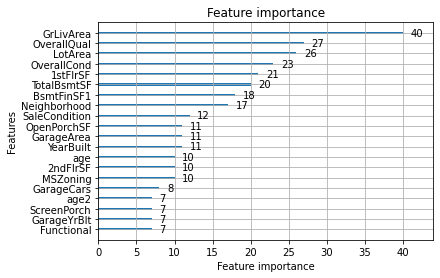

In [22]:
lgb.plot_importance(model,max_num_features=20)

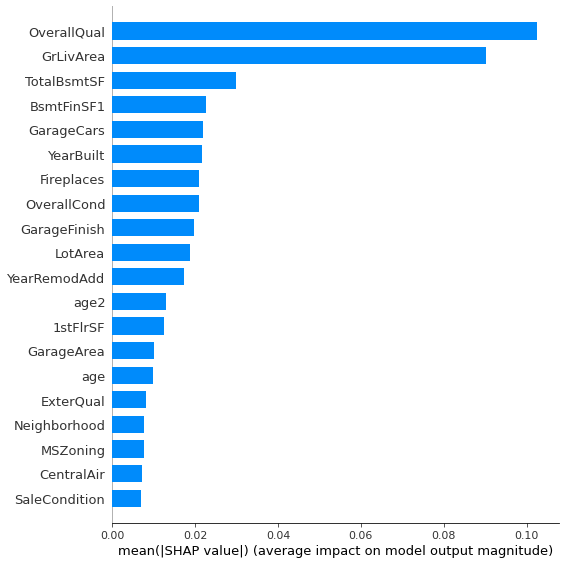

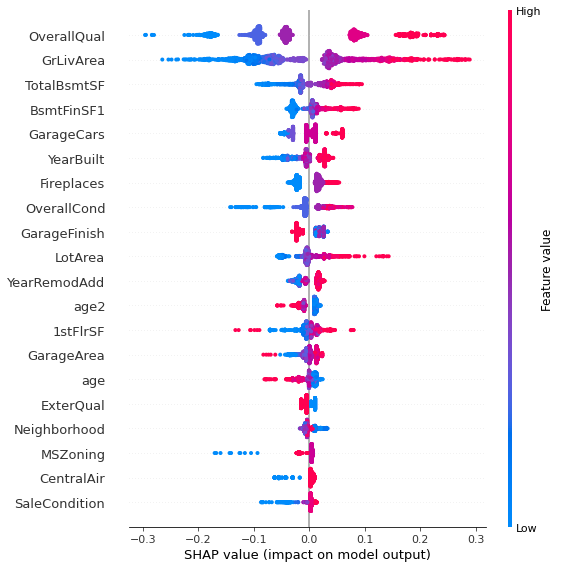

In [23]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
#importance
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)